#**<font color="#0b6623"> Classification Image Model</font>**

##**<font color="#0b6623"> Import Library</font>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import re
from re import U
from nltk.chat.util import Chat, reflections
import textwrap
import difflib

##**<font color="#0b6623"> Pre-Trained Model (InceptionV3)</font>**

In [ ]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze/Unfreeze the base model (to use pre-trained features)
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

In [ ]:
from keras.optimizers import SGD, Adam

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer='SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##**<font color="#0b6623"> Input Dataset</font>**

In [ ]:
DATA_DIR = '/content/drive/Shareddrives/Dataset/DatasetBaru'

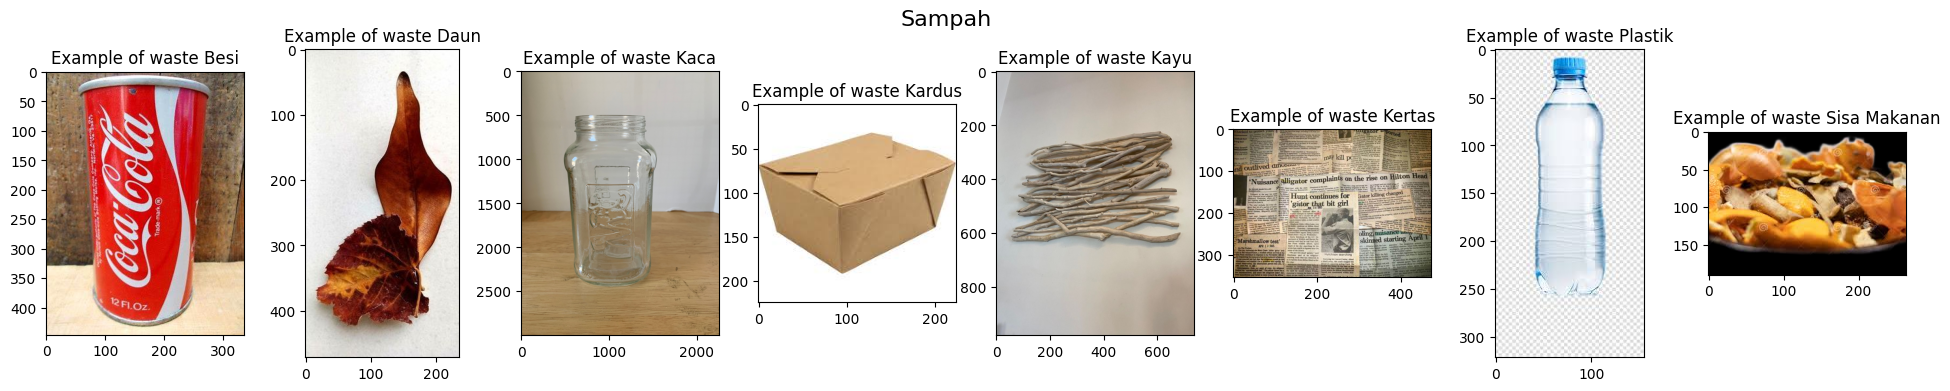

In [ ]:
fig, axes = plt.subplots(1, 8, figsize=(24, 4))
fig.suptitle('Sampah', fontsize=16)

for ii, waste in enumerate(['Besi', 'Daun', 'Kaca', 'Kardus', 'Kayu', 'Kertas', 'Plastik', 'Sisa Makanan']):
    dir = f'/content/drive/Shareddrives/Dataset/DatasetBaru/{waste}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of waste {waste}')

##**<font color="#0b6623"> Data Splitting</font>**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

batch_size = 32

# Load dataset
data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_directory(
    directory=DATA_DIR,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Ekstraksi data dan label dari generator
data, labels = [], []
for i in range(len(data_flow)):
    x, y = data_flow[i]
    data.extend(x)
    labels.extend(y)
data = np.array(data)
labels = np.array(labels)

# Membagi dataset menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=np.argmax(labels, axis=1)
)

Found 1652 images belonging to 8 classes.


##**<font color="#0b6623"> Training Model</font>**

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=batch_size
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 338ms/step - accuracy: 0.4831 - loss: 1.4897 - val_accuracy: 0.9305 - val_loss: 0.2950
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8950 - loss: 0.4265 - val_accuracy: 0.9396 - val_loss: 0.2226
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9543 - loss: 0.2059 - val_accuracy: 0.9486 - val_loss: 0.2093
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9604 - loss: 0.1613 - val_accuracy: 0.9517 - val_loss: 0.1859
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9806 - loss: 0.0965 - val_accuracy: 0.9517 - val_loss: 0.1904
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9763 - loss: 0.0791 - val_accuracy: 0.9486 - val_loss: 0.1860
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9790 - loss: 0.0779 - val_accuracy: 0.9517 - val_loss: 0.2022
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9877 - loss: 0.0490 - val_accuracy: 0.9577

##**<font color="#0b6623"> Loss and Accuracy</font>**

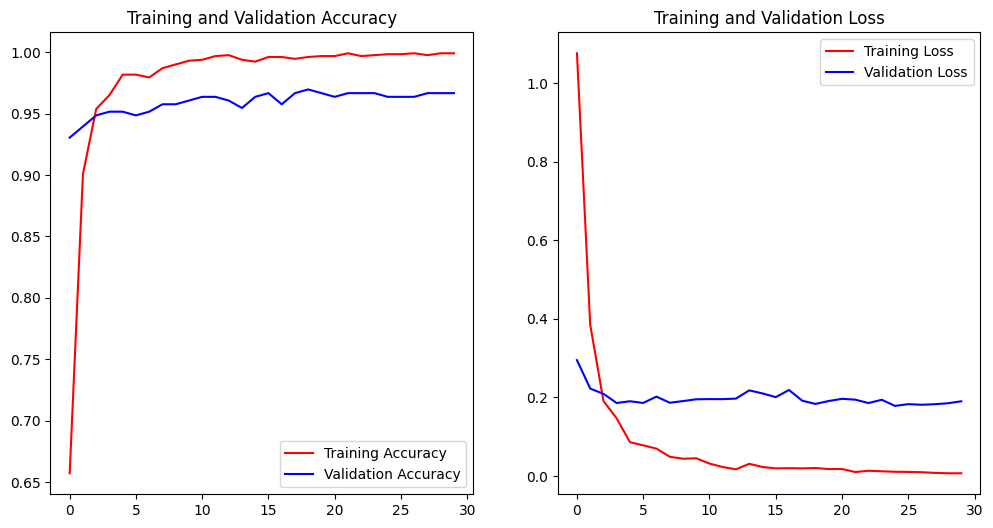

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

##**<font color="#0b6623"> Confusion Matrix</font>**

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step


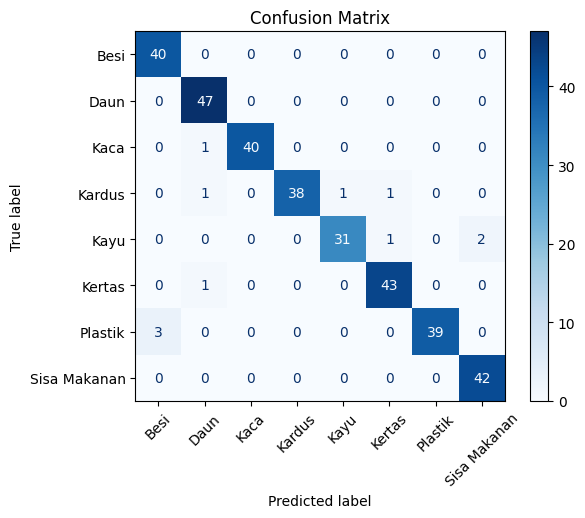

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi data validation
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Membuat confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_flow.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,066,090 (84.18 MB)

 Trainable params: 12,927,560 (49.31 MB)

 Non-trainable params: 9,138,528 (34.86 MB)

 Optimizer params: 2 (12.00 B)

##**<font color="#0b6623"> Save Model H5</font>**

In [ ]:
# Save model in SavedModel format
from google.colab import files

# Save model in H5 format
model.save('sampahio.h5')

# Download the model file
files.download('sampahio.h5')

"\n# Save model in SavedModel format\nfrom google.colab import files\n\n# Save model in H5 format\nmodel.save('sampahio.h5')\n\n# Download the model file\nfiles.download('sampahio.h5')\n"

##**<font color="#0b6623"> Convert TFLite</font>**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpgjbz9kse'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  140567747646160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494034352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494035056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494032240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494031536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494156448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494153984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565494155920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140567747644928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565493708080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405654940

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []
test_labels, test_imgs = [], []

# Menentukan jumlah gambar maksimal yang diproses secara total
max_images = 5
processed_images = 0  # Counter untuk gambar yang telah diproses

# Menggunakan tqdm untuk memantau progres
for img_batch, label_batch in tqdm(data_flow, total=len(data_flow)):
    for img, label in zip(img_batch, label_batch):  # Iterasi per gambar dalam batch
        if processed_images >= max_images:  # Stop jika sudah mencapai max_images
            break

        # Normalisasi gambar dan tetapkan ke tensor input
        interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))  # Tambahkan dimensi batch
        interpreter.invoke()

        # Ambil prediksi dari output tensor
        pred = interpreter.get_tensor(output_index)

        predictions.append(pred)
        test_labels.append(label)
        test_imgs.append(img)

        processed_images += 1  # Update jumlah gambar yang diproses

    if processed_images >= max_images:  # Stop loop utama jika sudah mencapai max_images
        break

  0%|          | 0/104 [00:00<?, ?it/s]


In [ ]:
# Utilities for plotting
class_names = ['Besi', 'Daun', 'Kaca', 'Kardus', 'Kayu', 'Kertas', 'Plastik', 'Sisa Makanan']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    # Konversi prediksi dan label asli ke scalar
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    print(type(predicted_label), type(true_label))

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100 * np.max(predictions_array),
        class_names[true_label]
    ), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


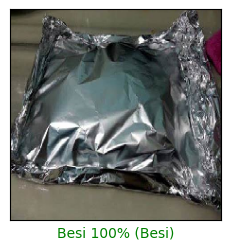

In [ ]:
# Visualize the outputs
index = 1
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**<font color="#0b6623"> ChatBot Rule Based</font>**

##**<font color="#0b6623"> Define Data</font>**

In [ ]:
data = {
  "topic": [
    [
      "Sampah Besi "
    ],
    [
      "Sampah Daun"
    ],
    [
      "Sampah Kaca"
    ],
    [
      "Sampah Kardus"
    ],
    [
      "Sampah Kayu"
    ],
    [
      "Sampah Kertas"
    ],
    [
      "Sampah Plastik"
    ],
    [
      "Sampah Sisa Makanan"
    ]

  ],
  "contents": [
    [
      "Sampah besi atau scrap besi adalah barang-barang besi yang sudah tidak terpakai lagi, seperti"
      "kaleng bekas atau komponen kendaraan. Meskipun kelihatannya hanya rongsokan, sebenarnya ini"
      "'harta karun'! Scrap besi bisa diolah lagi jadi bahan konstruksi, komponen mesin,atau karya seni."
      "Ada dua jenis sampah besi yaitu,ferrous (mengandung besi) dan non-ferrous (kayak aluminium)."
      "Dengan daur ulang, kita bisa hemat energi, kurangi limbah, dan bantu jaga lingkungan.",
    ],
    [
      "Sampah daun adalah bagian dari tumbuhan yang sudah tua atau rusak dan gugur dari pohon. Biasanya"
      "berupa daun kering berwarna coklat atau kehitaman. Meskipun sering dianggap sebagai sampah, daun"
      "kering punya banyak manfaat, lho! Misalnya, bisa dijadikan kompos untuk menyuburkan tanaman.",
    ],
    [
      "Sampah kaca adalah sisa-sisa material kaca yang sudah tidak terpakai, seperti botol, gelas, atau"
      "pecahan kaca. Bahan ini sulit terurai dan berbahaya jika tidak dikelola dengan baik. Yuk, kita"
      "sama-sama menjaga lingkungan dengan rajin memilah sampah kaca!",
    ],
    [
      "Sampah kardus adalah limbah yang terbuat dari kertas tebal. Biasanya digunakan untuk kemasan produk."
      "Kardus termasuk dalam kategori sampah organik yang bisa didaur ulang.Daur ulang kardus tidak hanya"
      "mengurangi sampah, tapi juga bisa menjadi bahan baku untuk membuat berbagai produk menarik,seperti"
      "kertas, furnitur, bahkan papan dinding!",
    ],
    [
      "Sampah kayu adalah sisa-sisa kayu yang sudah tidak terpakai lagi. Bisa berupa potongan-potongan kecil,"
      "serbuk gergaji, atau bahkan furnitur yang rusak. Sampah kayu ini bisa kita manfaatkan lagi, lho, misalnya"
      "dijadikan bahan bakar atau kompos.",
    ],
    [
      "Sampah kertas merupakan limbah yang dihasilkan dari penggunaan kertas yang sudah tidak terpakai. Kertas ini"
      "umumnya terbuat dari serat kayu yang diolah menjadi lembaran tipis. Selain koran dan kertas HVS, sampah kertas"
      "juga mencakup kardus, bungkus makanan berbahan kertas, dan kertas bekas lainnya. Sampah kertas termasuk dalam"
      "kategori sampah anorganik karena sulit terurai secara alami.",
    ],
    [
      "Sampah plastik adalah barang-barang bekas yang terbuat dari plastik. Plastik ini sulit terurai di alam dan bisa"
      "mencemari lingkungan jika tidak dikelola dengan baik. Sampah plastik bisa mencemari laut, tanah, dan udara. Selain itu,"
      "plastik juga bisa membahayakan satwa liar. Kita bisa mengurangi sampah plastik dengan membawa tas belanja sendiri,"
      "menggunakan botol minum yang bisa diisi ulang, dan mendaur ulang sampah plastik.",
    ],
    [
      "Sampah sisa makanan adalah makanan yang nggak dimakan atau dibuang setelah konsumsi, seperti tulang, kulit buah,"
      "atau makanan yang sudah kadaluarsa. Biasanya, sampah ini terdiri dari bahan organik yang mudah terurai, seperti nasi,"
      "sisa sayuran, atau buah yang udah nggak segar. Karena sifatnya yang organik,sampah sisa makanan bisa diolah jadi kompos"
      "atau diproses jadi limbah organik lain untuk mengurangi sampah di tempat pembuangan.",
    ]
  ],
  "questions": [
    [
      "Bagaimana cara mendaur ulang sampah besi dengan biaya yang efisien?",
      "Apa yang mempengaruhi harga jual sampah besi? ",
      "teknologi yang dapat diterapkan dalam proses daur ulang besi?",
      "Mengapa korosi pada besi menjadi masalah jika tidak didaur ulang?",
      "Apakah ada dampak negatif jika sampah besi tidak dikelola dengan baik?",
      "Apakah ada perbedaan nilai antara besi tua dan baja bekas?",
      "Apakah limbah besi dapat mencemari air tanah?",
      "Apakah besi memiliki batasan untuk didaur ulang?",
      "Apakah daur ulang besi dapat mengurangi penambangan?",
      "Apakah karat pada besi berbahaya?",
      "Apa peluang bisnis dari sampah besi?",
      "Bagaimana cara mengatasi tantangan dalam pengelolaan sampah besi?",
      "Apa yang terjadi pada sampah besi jika dibuang sembarangan?",
      "Berapa lama waktu yang dibutuhkan besi untuk terurai secara alami?",
      "Mengapa sampah besi lebih berharga dibandingkan jenis sampah lain?",
      "Mengapa penting memilah sampah besi dari jenis sampah lainnya?",
      "Bagaimana cara memilah sampah besi dengan benar?",
      "Apa yang bisa dilakukan individu dengan sampah besi di rumah?",
      "Apa bahaya membakar sampah besi?",
      "Apa jenis-jenis sampah besi yang umum ditemukan?"
    ],
    [
      "Bagaimana cara mengolah sampah daun menjadi kompos?",
      "Apakah sampah daun memiliki potensi sebagai pupuk cair?",
      "Bagaimana sampah daun memengaruhi kesuburan tanah?",
      "Bagaimana sampah daun bisa diubah menjadi bioplastik?",
      "Apa kendala utama dalam program pengelolaan sampah daun di masyarakat?",
      "Bagaimana mikroorganisme membantu menguraikan sampah daun?",
      "Berapa waktu yang diperlukan daun untuk terurai secara alami?",
      "Apakah sampah daun kering lebih cepat terurai dibandingkan sampah daun basah?",
      "Apakah sampah daun dapat menyebabkan eutrofikasi?",
      "Apa manfaat mendaur ulang daun dibandingkan membakar?",
      "Bagaimana cara membuat mulsa dari sampah daun?",
      "Bagaimana cara mengurangi bau sampah daun saat proses daur ulang?",
      "Apa itu metode \u201csheet composting\u201d untuk mendaur ulang sampah daun?",
      "Bisakah kompos daun menggantikan pupuk kimia?",
      "Bagaimana cara mengolah sampah daun di rumah tanpa alat khusus?",
      "Apa saja teknologi modern untuk mengolah sampah daun?",
      "Apa inovasi terbaru dalam pengelolaan sampah daun?",
      "Bagaimana cara memanfaatkan sampah daun untuk biopori?",
      "Apa saja komponen utama yang terkandung dalam daun sehingga dapat diolah menjadi pupuk organik?",
      "Apa perbedaan antara kompos dari sampah daun dengan kompos dari sisa makanan?"
    ],
    [
      "Apakah kaca yang pecah masih memiliki nilai jual?",
      "Bagaimana cara mengolah sampah kaca menjadi produk baru?",
      "Bagaimana peran teknologi dalam meningkatkan nilai jual sampah kaca?",
      "Apa inovasi terbaru dalam pengolahan sampah kaca?",
      "Apakah kaca harus dihancurkan sebelum didaur ulang?",
      "Apa yang dilakukan pada kaca yang sudah pecah?",
      "Apa metode pengolahan kaca untuk produk rumah tangga?",
      "Apakah semua jenis kaca dapat didaur ulang?",
      "Apa itu cullet dalam proses daur ulang kaca?",
      "Berapa lama waktu yang dibutuhkan untuk kaca terurai secara alami?",
      "Bagaimana cara membuang sampah kaca dengan aman?",
      "Apa perbedaan antara kaca bening dan kaca berwarna dalam proses daur ulang?",
      "Apakah kaca dapat membahayakan kehidupan laut?",
      "Apa yang dimaksud dengan kaca laminasi?",
      "Bagaimana cara sederhana untuk mengurangi sampah kaca?",
      "Mengapa kaca sering tidak didaur ulang?",
      "Apa Manfaat Daur Ulang sampah kaca?",
      "Berapa banyak limbah kaca yang bisa dikurangi dengan daur ulang?",
      "Apakah daur ulang kaca membutuhkan biaya tinggi?",
      "Bagaimana cara mengidentifikasi kaca yang bisa didaur ulang?"
    ],
    [
      "Apa saja metode yang efektif untuk mendaur ulang kardus bekas?",
      "Apakah semua jenis kardus bisa didaur ulang?",
      "Berapa kali kardus dapat didaur ulang?",
      "Bagaimana aplikasi teknologi dapat meningkatkan efisiensi daur ulang kardus?",
      "Bagaimana kardus diolah dalam proses daur ulang?",
      "Apakah kardus yang basah bisa didaur ulang?",
      "Berapa lama waktu yang diperlukan kardus untuk terurai secara alami?",
      "Apa dampak limbah kardus jika tidak dikelola dengan baik?",
      "Apa inovasi terbaru untuk mengoptimalkan daur ulang kardus?",
      "Apa yang dimaksud dengan kardus food grade?",
      "Apakah ada dampak sosial dari meningkatnya kesadaran akan pentingnya daur ulang kardus?",
      "Apa yang membedakan kardus bergelombang dan kardus biasa dalam proses daur ulang?",
      "Apa perbedaan penguraian kardus di tempat basah dan kering?",
      "Bagaimana cara membedakan kardus yang bisa dan tidak bisa didaur ulang?",
      "Bagaimana teknologi modern membantu pengelolaan sampah daun?",
      "Seberapa banyak emisi CO2 dapat dihemat dengan mendaur ulang kardus?",
      "Apakah mungkin menggunakan kardus sebagai media tanam?",
      "Bagaimana cara memilah kardus yang benar?",
      "Apakah ada perbedaan antara kardus makanan dan kardus biasa dalam hal daur ulang?",
      "Bagaimana cara membedakan kardus yang ramah lingkungan dengan yang tidak?"
    ],
    [
      "Apa saja produk bernilai tinggi yang dapat dihasilkan dari sampah kayu?",
      "Apakah teknologi daur ulang kayu dapat diterapkan untuk skala kecil?",
      "Teknologi apa yang bisa digunakan untuk memproses sampah kayu menjadi produk baru?",
      "Apa saja tantangan ekonomi yang dihadapi dalam pengelolaan sampah kayu?",
      "Apa dampak lingkungan dari pembakaran sampah kayu?",
      "Mengapa sampah kayu dianggap memiliki potensi ekonomis?",
      "Apa yang terjadi jika sampah kayu dibiarkan terlalu lama sebelum diolah?",
      "Apa saja metode pengolahan sampah kayu yang umum digunakan?",
      "Apakah pengolahan sampah kayu bisa dilakukan di skala rumah tangga?",
      "Bagaimana teknologi dapat membantu dalam pemilahan sampah kayu?",
      "Apa teknologi yang digunakan untuk mengurangi emisi dalam proses pembakaran kayu?",
      "Apakah ada jenis kayu yang tidak bisa didaur ulang?",
      "Apakah pembakaran sampah kayu berbahaya?",
      "Apa perbedaan antara limbah kayu alami dan limbah kayu industri?",
      "Bagaimana limbah kayu dapat dimanfaatkan dalam desain interior?",
      "Apa dampak limbah kayu terhadap ekosistem jika tidak dikelola?",
      "Apakah kayu dapat didaur ulang beberapa kali?",
      "Apa manfaat sosial dan ekonomi dari pengelolaan sampah kayu?",
      "Mengapa edukasi masyarakat tentang sampah kayu itu penting?",
      "Apakah waktu pengolahan memengaruhi biaya pengolahan sampah kayu?"
    ],
    [
      "Kertas apa saja yang dapat didaur ulang?",
      "Apa langkah pertama dalam memilah sampah kertas di rumah?",
      "Bisakah kertas yang sudah tercetak warna-warni dipilah untuk didaur ulang?",
      "Apa yang dapat dilakukan dengan kertas yang sudah tidak terpakai?",
      "Apakah penggunaan kertas daur ulang lebih ramah lingkungan dibandingkan kertas baru?",
      "Bagaimana cara mengurangi sampah kertas di rumah tangga?",
      "Apa saja keuntungan ekonomi dari pengolahan sampah kertas?",
      "Berapa lama kertas terurai secara alami?",
      "Bagaimana proses daur ulang kertas dilakukan?",
      "Apa produk yang bisa dihasilkan dari daur ulang kertas?",
      "Apa saja tantangan dalam mendaur ulang kertas?",
      "Apa inovasi terbaru dalam teknologi daur ulang kertas?",
      "Bagaimana cara kreatif mengurangi sampah kertas di rumah?",
      "Apa yang terjadi jika kertas daur ulang terus didaur ulang berulang kali?",
      "Mengapa penting untuk mengurangi penggunaan kertas meskipun kertas bisa didaur ulang?",
      "Apakah kertas thermal (seperti struk belanja) bisa didaur ulang?",
      "Bagaimana tinta memengaruhi proses daur ulang kertas?",
      "Apa komposisi utama kertas?",
      "Apakah ada spesies jamur yang mampu menguraikan kardus lebih cepat daripada mikroorganisme biasa?",
      "Mengapa proses daur ulang kertas memerlukan banyak air?"
    ],
    [
      "Apa yang bisa dilakukan untuk mengurangi sampah plastik di laut?",
      "Mengapa tidak semua plastik bisa didaur ulang?",
      "Apa yang terjadi jika plastik dibakar?",
      "Apa saja jenis plastik yang paling berbahaya bagi lingkungan?",
      "Apa saja jenis plastik yang dapat didaur ulang?",
      "Apa itu mikroplastik?",
      "Berapa lama plastik butuh waktu untuk terurai?",
      "Apa itu upcycling plastik?",
      "Apa perbedaan antara daur ulang mekanis dan daur ulang kimia?",
      "Apa itu plastik biodegradable?",
      "Apa itu pajak plastik?",
      "Apa perbedaan antara sampah plastik biodegradable dan non-biodegradable?",
      "Bagaimana sampah plastik berkontribusi terhadap perubahan iklim?",
      "Mengapa sampah plastik dianggap berbahaya?",
      "Apa saja produk ramah lingkungan pengganti plastik?",
      "Apakah waktu pengolahan sampah plastik mempengaruhi dampaknya terhadap lingkungan?",
      "Apa jenis sampah plastik paling berbahaya?",
      "Apa itu plastik sekali pakai?",
      "Apa saja upaya terbaru untuk mengurangi sampah plastik?",
      "Bagaimana sampah plastik mempengaruhi rantai makanan?"
    ],
    [
      "Mengapa penting memilah sisa makanan sebagai jenis sampah terpisah?",
      "Apa dampak positif memilah sisa makanan terhadap lingkungan?",
      "Bagaimana cara mengolah sisa makanan menjadi kompos?",
      "Apa saja bahan yang bisa digunakan untuk membuat biogas dari sisa makanan?",
      "Apa saja produk yang dapat dihasilkan dari pengolahan sisa makanan?",
      "Mengapa pengolahan sampah sisa makanan itu penting?",
      "Apa yang harus dilakukan dengan sisa makanan yang sudah busuk?",
      "Apa dampak dari tidak memisahkan sisa makanan dengan sampah lain?",
      "Apa yang dapat dilakukan dengan sisa makanan selain dibuang?",
      "Mengapa perlu memiliki tempat sampah terpisah untuk sisa makanan?",
      "Apa itu daur ulang sampah makanan (food waste recycling)?",
      "Apa perbedaan antara pengolahan sampah sisa makanan kompos dan biogas?",
      "Apa tantangan utama dalam mendaur ulang sampah sisa makanan?",
      "Apa itu food waste hierarchy?",
      "Apa saja contoh inovasi dalam daur ulang sampah sisa makanan?",
      "Apa metode pengolahan sampah sisa makanan yang umum digunakan?",
      "Apa saja alat yang dapat digunakan untuk mengolah sampah sisa makanan?",
      "Apa faktor yang mempengaruhi keberhasilan komposting sampah sisa makanan?",
      "Apakah ada teknologi sederhana untuk membuat biogas di rumah?",
      "Apa keuntungan sosial dari pengelolaan sampah makanan?"
    ]
  ],
  "answers": [
    [
      "1. Pengumpulan:\nFokus pada pengumpulan sampah besi dari sumber yang terkonsentrasi seperti lokasi konstruksi, pabrik, atau tempat pembongkaran kendaraan.\nKerjasama dengan pengumpul barang bekas untuk mengurangi biaya logistik.\n2. Pemilahan:\nGunakan magnet untuk memisahkan besi dari logam lain.\nProses ini dapat dilakukan secara manual untuk skala kecil atau menggunakan sistem otomatisasi berbasis sensor untuk skala besar.\n3. Pembersihan:\nHilangkan kontaminasi seperti plastik, cat, atau minyak menggunakan metode:\nPemanasan (untuk menghilangkan lapisan non-logam).\nLarutan kimia (untuk menghilangkan pelumas atau minyak).\n4. Penghancuran (Shredding):\nGunakan mesin penghancur (shredder) untuk mengubah besi menjadi potongan kecil sehingga lebih mudah diolah.\n5. Peleburan:\nBesi dilebur dalam tungku (blast furnace) atau tungku listrik (electric arc furnace) yang hemat energi.\nPilih teknologi tungku hemat bahan bakar untuk menekan biaya.\n6. Pembentukan Kembali:\nLogam yang sudah dilebur dicetak menjadi produk baru seperti baja lembaran, batang, atau blok.\n7. Optimalkan Energi:\nGunakan sumber energi terbarukan atau sistem pemulihan panas untuk mengurangi biaya operasional.",
      "1. Kualitas:\nSampah besi yang bersih dan bebas dari kontaminasi dihargai lebih tinggi.\nKandungan karbon atau unsur tambahan lain juga memengaruhi nilai jual.\n2. Kondisi Pasar:\nHarga besi tergantung pada permintaan global, terutama dari sektor konstruksi, otomotif, dan manufaktur.\n3. Kuantitas:\nSemakin besar jumlah besi yang dijual, semakin murah biaya logistik per unit, sehingga harga lebih kompetitif.\n4. Lokasi:\nBiaya transportasi dari tempat pengumpulan ke pabrik daur ulang memengaruhi margin keuntungan.\nJenis Besi:\n\nBesi murni dan baja tahan karat biasanya memiliki nilai lebih tinggi dibandingkan besi berkarat atau tercampur.",
      "1. Magnetic Separation:\nMemisahkan besi secara otomatis dari bahan lainnya dengan magnet berdaya tinggi.\n2. Shredders:\nMesin penghancur besar yang mampu mereduksi besi menjadi potongan kecil untuk efisiensi peleburan.\n3. Tungku Induksi atau Electric Arc Furnace (EAF):\nTeknologi hemat energi yang menggunakan listrik untuk melebur besi bekas menjadi bahan baru.\n4. Laser Sorting:\nTeknologi berbasis laser untuk memisahkan besi dari logam lain secara presisi.\n5. Sistem Pemulihan Panas:\nTeknologi yang memanfaatkan panas dari proses peleburan untuk mengurangi kebutuhan energi tambahan.\n6. Teknologi Peleburan Berbasis Hidrogen:\nMetode ramah lingkungan yang menggunakan hidrogen sebagai bahan bakar alternatif untuk mengurangi emisi karbon.",
      "1. Mengurangi Nilai Ekonomis:\nBesi yang berkarat lebih sulit diolah karena memerlukan proses tambahan untuk membersihkan oksidasi.\n2. Kerusakan Struktural:\nBesi berkarat yang digunakan kembali tanpa didaur ulang dapat menyebabkan kegagalan struktural pada produk akhir.\n3. Pencemaran Lingkungan:\nKorosi menghasilkan limbah kimia (seperti oksida besi) yang mencemari tanah dan air.\n4. Peningkatan Biaya Daur Ulang:\nBesi yang telah berkarat membutuhkan proses pengolahan yang lebih mahal untuk menghilangkan residu oksidasi.",
      "1. Pencemaran Lingkungan:\nBesi yang terbuang dapat berkarat dan melepaskan senyawa berbahaya ke tanah dan air.\n2. Limbah Visual:\nSampah besi menciptakan pemandangan yang tidak sedap dipandang, mengurangi estetika lingkungan.\n3. Kerugian Ekonomi:\nBesi bekas yang tidak didaur ulang adalah kehilangan potensi sumber daya yang dapat dimanfaatkan.\n4. Emisi Karbon Tinggi:\nProduksi besi baru membutuhkan lebih banyak energi dibandingkan proses daur ulang, sehingga menghasilkan lebih banyak emisi gas rumah kaca.\n5. Meningkatnya Volume TPA:\nSampah besi yang tidak dikelola memenuhi ruang di tempat pembuangan akhir (TPA), yang dapat digunakan untuk jenis limbah lainnya.\n",
      "1. Besi tua umumnya merujuk pada besi yang tidak mengandung banyak karbon dan relatif murni. Biasanya, besi tua berasal dari produk seperti rel kereta api, alat-alat berat, atau bahan konstruksi. Nilai jualnya lebih rendah dibandingkan baja bekas karena besi tua cenderung lebih mudah berkarat dan rapuh.\n2. Baja bekas merupakan logam campuran yang mengandung besi dan karbon, serta elemen lain seperti kromium atau nikel. Baja lebih tahan korosi dan memiliki kekuatan yang lebih tinggi. Oleh karena itu, baja bekas sering kali dihargai lebih tinggi dibandingkan besi tua, terutama jika berasal dari struktur berkualitas seperti mobil atau peralatan mesin.",
      "Limbah besi dapat mencemari air tanah, terutama jika materialnya sudah berkarat atau terpapar bahan kimia.\n1. Karat besi (oksida besi) dapat larut ke dalam air tanah dalam jumlah kecil. Meskipun senyawa ini biasanya tidak sangat beracun, kehadirannya dapat memengaruhi kualitas air tanah dengan menambah kadar logam berat.\n2. Jika limbah besi dicampur dengan bahan berbahaya seperti minyak, pelumas, atau residu kimia dari industri, risiko pencemaran jauh lebih tinggi. Zat-zat ini bisa menyerap ke dalam tanah dan mencemari air bawah tanah, berpotensi membahayakan lingkungan dan kesehatan manusia.",
      "Secara umum, besi tidak memiliki batasan dalam hal daur ulang. Namun, ada beberapa kendala teknis yang dapat memengaruhi kualitas hasil daur ulang:\n\n1. Kandungan Karbon: Proses daur ulang dapat mengubah kandungan karbon dalam besi, yang memengaruhi kekuatan dan sifat material.\n2. Kotoran dan Pengotor: Besi tua yang terkontaminasi oleh bahan lain (seperti plastik, cat, atau bahan kimia) dapat mempersulit proses peleburan dan menurunkan kualitas produk akhir.\n3. Efisiensi Proses: Pada beberapa kasus, efisiensi energi dan biaya dalam mendaur ulang besi tua mungkin lebih rendah dibandingkan menambang besi baru jika bahan terlalu terkontaminasi.\nNamun, secara keseluruhan, besi merupakan salah satu material yang sangat ramah daur ulang karena sifatnya yang dapat diproses ulang tanpa kehilangan kekuatan atau sifat dasarnya.",
      "1. Dengan mendaur ulang besi tua, kita bisa mengurangi konsumsi energi dan sumber daya yang diperlukan dalam penambangan dan pengolahan bijih besi. Proses peleburan besi daur ulang jauh lebih hemat energi dibandingkan mengekstraksi dan memproses bijih baru.\n2. Mengurangi penambangan juga membantu menjaga kelestarian lingkungan dengan meminimalkan kerusakan ekosistem, emisi karbon, dan polusi yang dihasilkan dari aktivitas penambangan.",
      "Karat pada besi biasanya tidak berbahaya dalam jumlah kecil, tetapi dapat menjadi masalah dalam beberapa kondisi:\n\n1. Untuk Struktur dan Keamanan: Karat dapat melemahkan kekuatan besi, sehingga berbahaya jika terjadi pada struktur seperti jembatan, bangunan, atau alat berat.\n2. Untuk Kesehatan: Jika karat terpapar ke makanan atau air minum, senyawa oksida besi bisa berkontribusi pada peningkatan kadar zat besi dalam tubuh. Meski zat besi adalah nutrisi penting, kelebihan kadar besi dapat menyebabkan masalah kesehatan, seperti hemochromatosis.\n3. Lingkungan: Jika karat dari besi menyebar ke tanah atau air, ia dapat meningkatkan kadar zat besi dalam ekosistem. Hal ini dapat mengganggu keseimbangan kimiawi tanah atau air, meskipun pengaruhnya relatif kecil dibandingkan polutan kimia lainnya.",
      "Sampah besi memiliki nilai ekonomi yang tinggi karena sifatnya yang dapat didaur ulang tanpa mengurangi kualitasnya. Berikut adalah peluang bisnis dari sampah besi:\n1. Pengepul Besi Tua (Scrap Metal Collector): Mengumpulkan besi bekas dari berbagai sumber seperti bangunan yang direnovasi atau dihancurkan, kendaraan bekas, atau limbah industri untuk dijual kembali.\n2. Daur Ulang Besi: Besi dapat dilebur untuk dijadikan bahan baku dalam produksi baru, seperti baja untuk konstruksi atau produk manufaktur.\n3. Pembuatan Barang Industri atau Rumah Tangga: Besi bekas dapat digunakan untuk membuat peralatan sederhana, kerajinan, atau furnitur.\n4. Ekspor Besi Tua: Banyak negara yang memiliki kebutuhan tinggi akan besi tua untuk industri mereka, sehingga ini membuka peluang ekspor.\n5. E-commerce untuk Besi Bekas: Membuat platform digital khusus untuk transaksi jual beli besi bekas antara konsumen, pengepul, dan industri.",
      "1. Peningkatan Infrastruktur Daur Ulang: Membangun lebih banyak fasilitas pengolahan dan daur ulang besi.\n2. Sosialisasi dan Pendidikan: Meningkatkan kesadaran masyarakat tentang pentingnya pengelolaan sampah besi, seperti membedakan jenis logam dan membawanya ke pusat daur ulang.\n3. Insentif Pemerintah: Memberikan subsidi atau insentif pajak untuk bisnis yang bergerak di bidang pengelolaan besi bekas.\n4. Kemitraan dengan Industri: Membuat perjanjian dengan industri untuk mengambil limbah besi secara teratur.\n5. Teknologi Canggih: Menggunakan teknologi untuk memisahkan besi dari limbah campuran secara efisien.\n6. Penegakan Regulasi: Menerapkan undang-undang tentang pengelolaan limbah besi agar tidak dibuang sembarangan.",
      "1. Dampak Lingkungan: Besi yang terpapar elemen cuaca dapat berkarat dan melepaskan senyawa berbahaya ke dalam tanah dan air.\n2. Polusi Visual: Besi tua sering kali menciptakan pemandangan yang tidak sedap di lahan kosong atau tempat pembuangan akhir.\n3. Peluang Ekonomi yang Terbuang: Nilai ekonomis dari besi bekas tidak dimanfaatkan jika hanya dibuang.\n4. Bahaya Fisik: Besi berkarat atau tajam dapat menyebabkan cedera bagi manusia atau hewan.\n5. Peningkatan Beban TPA (Tempat Pembuangan Akhir): Besi sulit terurai sehingga akan terus menumpuk di TPA.",
      "Besi membutuhkan 50 hingga 500 tahun untuk terurai secara alami, tergantung pada kondisi lingkungan seperti kelembapan dan kadar oksigen. Proses ini melibatkan korosi (karat), yang meskipun mengurai struktur besi, tetap meninggalkan residu logam di lingkungan.",
      "1. Dapat Didaur Ulang Tanpa Kehilangan Kualitas: Besi dan baja dapat dilebur dan digunakan kembali tanpa perubahan signifikan pada sifat materialnya.\n2. Permintaan Tinggi di Industri: Industri konstruksi, otomotif, dan manufaktur memerlukan besi dalam jumlah besar.\n3. Nilai Ekonomis Tinggi: Harga besi bekas di pasar relatif tinggi dibandingkan dengan jenis sampah lain seperti plastik atau kertas.\n4. Penghematan Energi: Daur ulang besi menghemat energi dibandingkan memproduksi besi dari bijih mentah.\n5. Keberlanjutan: Menggunakan kembali besi bekas mendukung prinsip ekonomi sirkular dan mengurangi kebutuhan untuk menambang bahan mentah baru.",
      "Memilah sampah besi dari jenis sampah lainnya sangat penting untuk beberapa alasan:\n\n1. Mendaur ulang dengan efisien: Besi merupakan salah satu material yang mudah didaur ulang, dan memilahnya memudahkan proses pemrosesan dan pendauran ulang. Besi yang terpisah dari sampah lain dapat langsung diproses dalam fasilitas daur ulang tanpa kontaminasi bahan lain.\n2. Mengurangi dampak lingkungan: Dengan mendaur ulang besi, kita mengurangi kebutuhan untuk menambang besi baru, yang memerlukan energi besar dan berpotensi merusak lingkungan. Proses daur ulang lebih hemat energi dan mengurangi emisi karbon.\n3. Mengurangi pencemaran: Memisahkan besi dari sampah lainnya mengurangi pencemaran yang dihasilkan dari limbah yang tercampur dan mengarah pada pengelolaan sampah yang lebih baik.",
      "1. Pisahkan dari sampah lainnya: Kumpulkan barang-barang yang terbuat dari besi, seperti kaleng minuman, peralatan rumah tangga kecil, atau potongan besi dari barang rusak.\n2. Bersihkan sampah besi: Sebelum dibuang, pastikan sampah besi bebas dari bahan lain, seperti plastik atau kertas, yang dapat mengganggu proses daur ulang. Cuci barang-barang besi jika diperlukan.\n3. Pisahkan menurut jenisnya: Kadang-kadang besi bisa tercampur dengan jenis logam lainnya seperti aluminium atau tembaga. Pisahkan besi dari logam lain untuk memudahkan proses pengolahan lebih lanjut.\n4. Perhatikan kondisi besi: Jika memungkinkan, pisahkan antara besi tua dan barang-barang besi yang masih bisa digunakan atau diperbaiki untuk mengurangi limbah yang tidak perlu.",
      "1. Daur ulang: Sebagian besar barang besi seperti kaleng atau pipa besi dapat didaur ulang. Anda bisa mengumpulkannya dan mengirimkannya ke pusat daur ulang lokal.\n2. Mendaur ulang kreatif: Jika memiliki keterampilan DIY, Anda bisa mendaur ulang barang besi yang tidak terpakai menjadi barang baru, seperti perabot rumah tangga, kerajinan tangan, atau dekorasi.\n3. Menjual: Beberapa jenis besi, seperti besi tua atau besi konstruksi, dapat dijual kepada pengepul logam atau pusat daur ulang. Ini memberikan nilai tambah pada sampah besi.\n4. Menggunakan untuk keperluan lain: Beberapa barang besi seperti kawat besi bisa digunakan untuk keperluan lain di rumah, seperti membuat pagar atau untuk keperluan berkebun.",
      "1. Pencemaran udara: Pembakaran besi bisa menyebabkan pembentukan asap berbahaya dan melepaskan zat beracun ke udara, terutama jika besi terkontaminasi dengan bahan kimia atau logam lain seperti plastik atau cat.\n2. Kebakaran: Sampah besi yang dibakar dapat menyebabkan api yang tidak terkendali, yang berisiko merusak properti dan membahayakan keselamatan pribadi.\n3. Melepaskan bahan berbahaya: Beberapa jenis besi dapat memiliki pelapis atau bahan kimia yang, jika terbakar, dapat mengeluarkan gas berbahaya seperti karbon monoksida atau logam berat yang beracun.",
      "Jenis-jenis sampah besi yang umum ditemukan meliputi:\n\n1. Kaleng: Seperti kaleng minuman atau kaleng makanan yang terbuat dari besi.\n2. Peralatan rumah tangga: Seperti panci besi, oven, atau barang-barang rumah tangga lainnya yang sudah rusak.\n3. Besi konstruksi: Potongan-potongan besi dari pembangunan atau perbaikan rumah, seperti paku, baut, atau besi bekas.\n4. Peralatan elektronik: Beberapa peralatan elektronik yang mengandung komponen besi, seperti komputer atau televisi.\n5. Alat-alat pertanian: Seperti alat bercocok tanam yang terbuat dari besi atau baja.\n6. Perabotan rusak: Seperti furnitur besi tua atau rusak yang sudah tidak digunakan lagi."
    ],
    [
      "Mengolah sampah daun menjadi kompos melibatkan proses dekomposisi bahan organik oleh mikroorganisme. Berikut adalah langkah-langkah untuk mengolah sampah daun menjadi kompos:\n\n1. Pengumpulan dan Persiapan Daun: Kumpulkan daun-daun kering yang telah jatuh dari pohon. Anda bisa memotong daun menjadi potongan kecil agar mempercepat proses penguraian.\n\n2. Membuat Tumpukan Kompos: Buat tumpukan kompos di tempat yang teduh dan terlindung dari hujan langsung. Gunakan wadah atau area tanah yang berventilasi baik untuk memudahkan pertukaran udara.\n\n3. Menambahkan Bahan Pengikat dan Pengurai: Campurkan sampah daun dengan bahan organik lainnya, seperti sisa sayuran, rumput, atau sampah dapur. Ini untuk memberikan keseimbangan karbon dan nitrogen yang dibutuhkan untuk proses dekomposisi.\n\n4. Kelembapan dan Ventilasi: Pastikan tumpukan kompos tetap lembap, tetapi tidak terlalu basah. Aduk tumpukan kompos secara berkala untuk memastikan udara masuk, yang membantu proses penguraian oleh mikroorganisme.\n\n5. Waktu Penguraian: Proses dekomposisi biasanya memakan waktu antara 2-6 bulan tergantung pada kondisi lingkungan dan ukuran bahan yang digunakan.\n\n6. Penyaringan dan Penyimpanan: Setelah kompos matang, saring dan pisahkan dari bahan yang belum terurai sempurna, lalu simpan kompos siap pakai untuk digunakan sebagai pupuk.",
      "Sampah daun bisa diolah menjadi pupuk cair melalui proses fermentasi. Pupuk cair dari sampah daun mengandung nutrisi seperti nitrogen, fosfor, dan kalium, yang bermanfaat untuk tanaman. Berikut adalah cara membuat pupuk cair dari sampah daun:\n\n1. Bahan-bahan: Daun-daun yang sudah dipotong kecil, air, dan beberapa bahan lain seperti gula merah atau molase untuk mempercepat fermentasi.\n\n2. Proses: Tempatkan daun yang sudah dipotong dalam wadah besar, tambahkan air secukupnya, dan beri sedikit gula merah untuk mendukung perkembangan mikroorganisme. Tutup wadah dengan rapat, dan biarkan selama beberapa minggu. Aduk sesekali untuk menghindari pembusukan.\n\n3. Penggunaan: Setelah fermentasi selesai, saring cairan tersebut dan gunakan sebagai pupuk cair untuk tanaman. Pupuk cair dari sampah daun kaya akan unsur hara yang dapat mempercepat pertumbuhan tanaman.",
      "Sampah daun dapat meningkatkan kesuburan tanah dengan beberapa cara:\n\n1. Menambah Materi Organik: Saat terurai, daun-daun yang jatuh menjadi materi organik yang kaya akan nutrisi. Hal ini meningkatkan kadar bahan organik dalam tanah, yang berfungsi sebagai sumber makanan bagi mikroorganisme tanah.\n\n2. Meningkatkan Struktur Tanah: Bahan organik yang berasal dari daun dapat memperbaiki struktur tanah, meningkatkan kemampuan tanah untuk menahan air, dan memperbaiki drainase tanah.\n\n3. Menambah Keanekaragaman Hayati Tanah: Dekomposisi daun menarik mikroorganisme tanah, yang mendukung keberagaman hayati di dalam tanah. Mikroorganisme ini berperan dalam siklus hara dan membantu tanaman menyerap nutrisi lebih baik.\n\nMenjaga pH Tanah: Sampah daun dapat membantu menstabilkan pH tanah, membuatnya lebih cocok untuk pertumbuhan tanaman yang membutuhkan tanah dengan pH tertentu.",
      "Sampah daun, terutama yang kaya akan selulosa, bisa digunakan untuk membuat bioplastik. Berikut adalah cara dasar untuk mengubah sampah daun menjadi bioplastik:\n\n1. Persiapan Daun: Kumpulkan daun dan potong kecil-kecil. Rebus daun dalam air selama beberapa jam untuk melarutkan selulosa yang terkandung dalam daun.\n\n2. Pembuatan Larutan Selulosa: Setelah direbus, ekstrak larutan selulosa dengan menyaring daun dan memisahkan air rebusan yang mengandung selulosa terlarut. Tambahkan bahan pengikat lain seperti gliserol atau asam asetat untuk memperbaiki sifat bioplastik.\n\n3. Proses Pencetakan: Rebus campuran larutan selulosa dengan bahan pengikat hingga mengental, lalu tuangkan ke dalam cetakan dan biarkan mengering selama beberapa hari untuk membentuk plastik.\n\n4. Penggunaan: Bioplastik dari sampah daun ini dapat digunakan untuk berbagai aplikasi, seperti pembungkus makanan atau produk sekali pakai lainnya yang ramah lingkungan.",
      "Beberapa kendala utama dalam program pengelolaan sampah daun di masyarakat antara lain:\n\n1. Kurangnya Kesadaran Masyarakat: Banyak orang belum memahami pentingnya pengelolaan sampah daun secara tepat, sehingga mereka cenderung membuang daun begitu saja tanpa memikirkan manfaat yang dapat diperoleh dari pengolahannya.\n\n2. Infrastruktur Pengelolaan yang Terbatas: Di banyak daerah, tidak ada fasilitas atau layanan pengelolaan sampah daun yang memadai, seperti tempat komposting atau pusat pengolahan sampah daun.\n\n3. Proses Pengolahan yang Memerlukan Waktu: Proses pengolahan sampah daun menjadi kompos atau pupuk cair memerlukan waktu yang cukup lama, dan tidak semua orang sabar untuk menunggu hingga kompos matang atau pupuk cair siap digunakan.\n\n4. Pengumpulan yang Tidak Efisien: Pengumpulan sampah daun sering kali tidak terorganisir dengan baik, sehingga banyak daun yang terbuang tanpa pemanfaatan yang maksimal.\n\nFaktor Lingkungan: Beberapa daerah mengalami masalah dengan curah hujan yang tinggi, yang dapat memperlambat proses komposting atau membuat sampah daun terkontaminasi dengan bahan lain.",
      "Mikroorganisme seperti bakteri, jamur, dan aktinomisetes berperan penting dalam dekomposisi daun. Mereka memecah senyawa organik kompleks di daun, seperti selulosa, hemiselulosa, dan lignin, menjadi senyawa yang lebih sederhana seperti karbon dioksida, air, dan humus. Proses ini melibatkan tahapan:\n\n1. Fragmentasi: Organisme seperti cacing tanah dan serangga membantu menghancurkan daun menjadi potongan-potongan kecil, meningkatkan luas permukaan untuk mikroorganisme.\n2. Degradasi Enzimatik: Mikroorganisme menghasilkan enzim (seperti selulase) untuk memecah molekul kompleks.\n3. Pembentukan Humus: Senyawa yang lebih stabil diubah menjadi humus, yang memperbaiki struktur tanah dan menyimpan nutrisi.",
      "Waktu yang dibutuhkan daun untuk terurai bergantung pada faktor seperti jenis daun, kelembaban, suhu, dan keberadaan mikroorganisme. Secara umum:\n\n1. Daun tipis (misalnya rumput): Terurai dalam 3-6 bulan.\n2. Daun tebal dengan kandungan lignin tinggi (misalnya daun mangga): Terurai dalam 6-24 bulan.\n3. Kondisi optimal (kelembapan tinggi, suhu hangat, banyak mikroorganisme) mempercepat proses, sedangkan kondisi kering atau dingin memperlambatnya.",
      "Sampah Daun Kering:\n1. Cenderung lebih lambat terurai karena kekurangan kelembaban, yang diperlukan untuk aktivitas mikroorganisme.\n2. Daun kering sering kali memiliki lebih banyak lignin, yang sulit didekomposisi.\nSampah Daun Basah:\n3. Lebih cepat terurai karena kelembaban mendukung aktivitas mikroorganisme.\n2. Daun basah lebih rentan terhadap serangan jamur dan bakteri.\n3. Namun, daun basah yang menumpuk dapat menciptakan kondisi anaerob, memperlambat proses karena hanya mikroorganisme tertentu yang dapat bekerja tanpa oksigen.",
      "Sampah daun dapat menyebabkan eutrofikasi jika masuk ke badan air. Ketika daun terurai di air:\n\n1. Nutrisi seperti nitrogen dan fosfor dilepaskan, yang dapat memacu pertumbuhan alga secara berlebihan.\n2. Alga yang mati akan terurai oleh bakteri, yang menghabiskan oksigen terlarut di air, menyebabkan hipoksia (kekurangan oksigen).\n3. Kondisi ini dapat membunuh organisme air seperti ikan dan menyebabkan kerusakan ekosistem.",
      "1. Manfaat Lingkungan:\na. Mengurangi emisi karbon dioksida dan partikel berbahaya seperti PM2.5 yang dilepaskan saat pembakaran.\nb. Menjaga kualitas udara dan mengurangi polusi.\n2. Manfaat untuk Tanah:\na. Kompos dari daun memperbaiki struktur tanah, meningkatkan kesuburan, dan kapasitas retensi air.\nb. Humus dari daun menambahkan bahan organik, memperbaiki mikroflora tanah.\n3. Ekonomi:\na. Menghemat biaya pembelian pupuk dan media tanam.\n4. Ekologis:\na. Meningkatkan keberlanjutan siklus ekosistem karena daun yang didaur ulang kembali menjadi bagian dari siklus karbon dan nitrogen.",
      "Mulsa dari sampah daun dapat dibuat dengan cara sederhana:\n\n1. Pengumpulan: Kumpulkan daun kering atau basah dari halaman atau lingkungan sekitar. Pastikan tidak ada sampah plastik, logam, atau bahan non-organik.\n2. Pencacahan: Cacah daun menggunakan mesin pencacah, gunting taman, atau remukkan secara manual untuk mempercepat proses dekomposisi dan mempermudah penyebaran.\n3. Pengeringan (opsional): Jika daun basah, jemur di bawah sinar matahari hingga kering untuk mengurangi risiko pembusukan berlebih saat diaplikasikan.\n4. Pengaplikasian: Sebarkan daun yang sudah dicacah di permukaan tanah di sekitar tanaman. Pastikan lapisannya tidak terlalu tebal (maksimal 5 cm) untuk mencegah kelembaban berlebihan.",
      "Untuk mengurangi bau yang mungkin muncul selama proses daur ulang, ikuti langkah berikut:\n\n1. Pencampuran bahan: Kombinasikan daun dengan bahan karbon tinggi (seperti serpihan kayu, sekam padi, atau kertas). Ini membantu menyeimbangkan rasio karbon dan nitrogen yang mengurangi bau busuk.\n2. Aerasi: Pastikan tumpukan daun memiliki ventilasi yang baik. Balik atau aduk secara rutin untuk menjaga aliran udara dan mencegah zona anaerobik.\n3. Pemberian mikroorganisme: Tambahkan aktivator kompos atau campurkan sedikit tanah ke tumpukan daun untuk mempercepat proses dekomposisi.\n4. Pengendalian kelembaban: Pastikan tumpukan tidak terlalu basah; jika basah, tambahkan bahan kering seperti serbuk gergaji.",
      "Sheet composting adalah metode mendaur ulang bahan organik langsung di tanah, tanpa perlu kompos tradisional. Caranya:\n\n1. Penyebaran langsung: Sebarkan sampah daun di permukaan tanah yang kosong atau di sekitar tanaman.\n2. Pengomposan alami: Biarkan daun membusuk secara alami selama beberapa bulan.                      3. Mikroorganisme di tanah akan memecah daun menjadi humus yang kaya nutrisi.\n4. Alternatif penguburan: Untuk mempercepat, daun bisa ditimbun dengan tanah tipis (1\u20132 cm) agar lebih cepat terurai.",
      "Kompos daun bisa menggantikan sebagian fungsi pupuk kimia, terutama untuk memperbaiki struktur tanah dan meningkatkan kesuburan secara alami. Namun, perlu diingat:\n\n1. Kandungan nutrisi: Kompos daun cenderung rendah nitrogen dibandingkan pupuk kimia. Jika tanaman membutuhkan nutrisi cepat, pupuk organik lain atau tambahan nitrogen mungkin diperlukan.\n2. Penggunaan jangka panjang: Kompos daun sangat efektif dalam memperbaiki kapasitas tanah menahan air dan nutrisi, meningkatkan aktivitas mikroorganisme, serta memperbaiki keseimbangan tanah dalam jangka panjang.\nKombinasi kompos daun dan pupuk organik lainnya bisa menjadi solusi berkelanjutan tanpa ketergantungan pada pupuk kimia.",
      "Mengolah sampah daun tanpa alat khusus bisa dilakukan dengan beberapa langkah sederhana:\n\n1. Pengumpulan: Kumpulkan daun yang akan diolah dan pastikan bebas dari sampah non-organik.\n2. Tumpukan sederhana: Buat tumpukan daun di sudut halaman.\n3. Layering (lapisan): Susun daun secara bertumpuk, dan selingi dengan bahan hijau (seperti sisa dapur) serta sedikit tanah untuk mempercepat dekomposisi.\n4. Penambahan air: Siram tumpukan secara berkala, tetapi pastikan tidak terlalu basah.\n5. Aduk manual: Gunakan garpu taman atau tongkat untuk mengaduk tumpukan setiap 2\u20133 minggu agar tetap teroksigenasi.",
      "1. Mesin Pencacah Daun\nMesin ini membantu mencacah daun menjadi potongan kecil sehingga proses penguraian lebih cepat.\n2. Komposter Otomatis\nTeknologi ini menggunakan sistem pemanasan otomatis, aerasi, dan kontrol kelembapan untuk mempercepat pengomposan.\n3. Biodigester\nMengolah sampah daun menjadi biogas dan residu organik yang dapat digunakan sebagai pupuk.\n4. Nanoteknologi\nDigunakan untuk mempercepat proses penguraian dengan menambahkan katalis berbasis nano-material yang mempercepat aktivitas mikroba.\n5. Bio-Enzim\nMenggunakan enzim yang dihasilkan dari mikroorganisme untuk menguraikan serat daun secara efisien.\n",
      "Beberapa inovasi terkini dalam pengelolaan sampah daun meliputi:\n\n1. Eco-Enzyme\n    Mengolah sampah daun menjadi larutan eco-enzyme yang berguna sebagai pembersih alami atau pupuk cair.\n2. Pembuatan Biochar\n    Daun kering dikarbonisasi dalam kondisi minim oksigen untuk menghasilkan biochar, yang dapat meningkatkan kesuburan tanah dan menyerap karbon.\n3. Bahan Baku Bio-Plastik\n    Serat daun diolah menjadi bio-plastik yang biodegradable.\n4. Pengolahan dengan Jamur\n    Memanfaatkan jamur tertentu (misalnya, jamur lignolitik) untuk mengurai daun menjadi bahan yang kaya nutrisi.",
      "Lubang biopori adalah metode sederhana untuk memanfaatkan sampah daun. Berikut adalah langkah-langkahnya:\n\n1. Membuat Lubang Biopori\n    Gali lubang dengan diameter 10\u201330 cm dan kedalaman 50\u2013100 cm.\n2. Mengisi Lubang dengan Sampah Daun\n    Masukkan daun kering atau basah ke dalam lubang hingga penuh. Hindari memasukkan bahan anorganik.\n3. Penutupan dan Pemeliharaan\n    Tutup permukaan lubang dengan pelindung (seperti kawat) untuk mencegah hewan mengganggu.\n4. Proses Penguraian\n    Mikroorganisme dalam tanah akan mengurai daun menjadi kompos yang memperbaiki struktur tanah dan menyerap air hujan.\n5. Manfaat biopori dari sampah daun:\n    a. Meningkatkan resapan air tanah.\n    b. Mengurangi sampah organik di permukaan.\n    c. Memperbaiki kesuburan tanah secara alami.",
      "1. Nitrogen (N)\n    Membantu pertumbuhan daun dan tunas pada tanaman.\n2. Fosfor (P)\n    Mendukung perkembangan akar dan pembentukan bunga.\n3. Kalium (K)\n    Berfungsi untuk meningkatkan kekuatan tanaman terhadap penyakit.\n4. Serat dan Selulosa\n    Menyediakan bahan organik yang dapat meningkatkan struktur tanah.\n5. Mikronutrien\n    Seperti kalsium, magnesium, dan zat besi yang membantu metabolisme tanaman.\n6. Lignin dan Tanin\n    Walaupun lebih lambat terurai, lignin bermanfaat sebagai pelepas hara jangka panjang.\n",
      "Perbedaan antara kompos dari sampah daun dan kompos dari sisa makanan terletak pada bahan baku, proses dekomposisi, kandungan nutrisi, serta aplikasi penggunaannya:\n\n1. Bahan Baku\n    a. Sampah Daun: Berasal dari bahan organik kering seperti daun, ranting, dan rumput. Cenderung tinggi karbon (C).\n    b. Sisa Makanan: Berasal dari limbah dapur seperti sayur, buah, dan sisa nasi. Cenderung tinggi nitrogen (N).\n2. Proses Dekomposisi\n    a. Sampah Daun: Dekomposisi lebih lambat karena bahan cenderung lebih kering dan keras, membutuhkan tambahan nitrogen atau aktivator untuk mempercepat proses.\n    b. Sisa Makanan: Lebih cepat terurai karena kadar air tinggi dan mudah dicerna oleh mikroorganisme.\n3. Kandungan Nutrisi\n    a. Sampah Daun: Kompos cenderung lebih kaya karbon, cocok untuk memperbaiki struktur tanah.\n    b. Sisa Makanan: Kandungan nitrogen lebih tinggi, cocok untuk menyuburkan tanah secara langsung.\n4. Bau dan Risiko\n    a. Sampah Daun: Tidak berbau menyengat, relatif bersih, dan jarang menarik hama.\n    b. Sisa Makanan: Berpotensi mengeluarkan bau tidak sedap dan menarik hama jika tidak dikelola dengan baik.\n5. Aplikasi\n    a. Sampah Daun: Lebih cocok untuk mulsa atau memperbaiki tekstur tanah dalam jangka panjang.\n    b. Sisa Makanan: Baik untuk tanaman yang membutuhkan nutrisi tinggi secara cepat, seperti sayuran."
    ],
    [
      "Kaca yang pecah masih memiliki nilai jual, terutama jika diolah kembali menjadi bahan atau produk baru. Nilainya tergantung pada kondisi kaca (bersih atau tidak), jenis kaca (misalnya kaca bening, kaca warna, atau kaca tempered), dan kebutuhan pasar. Industri daur ulang biasanya membeli kaca pecah sebagai bahan baku untuk produk baru seperti kaca bangunan, botol, atau kerajinan tangan. Selain itu, kaca pecah juga diminati oleh seniman dan pengrajin untuk pembuatan mosaik atau karya seni.",
      "Pengolahan sampah kaca menjadi produk baru melibatkan beberapa tahap berikut:\r\n\r\n1. Pengumpulan dan Pemisahan\r\nSampah kaca dikumpulkan dan dipisahkan berdasarkan jenis dan warna. Misalnya, kaca bening, hijau, atau coklat harus dipisahkan untuk menghindari kontaminasi.\r\n2. Pembersihan\r\nKaca dibersihkan dari kotoran, label, atau residu lainnya yang dapat mengganggu proses daur ulang.\r\n3. Penghancuran\r\nKaca dihancurkan menjadi serpihan kecil yang disebut cullet. Proses ini mempermudah pencairan kaca dalam proses produksi berikutnya.\r\n4. Peleburan\r\nCullet dilebur dalam suhu tinggi dan dicampur dengan bahan tambahan sesuai kebutuhan produk akhir.\r\n5. Pencetakan dan Pembentukan\r\nKaca cair dicetak menjadi produk baru seperti botol, kaca jendela, ubin kaca, atau peralatan dekoratif.\r\n6. Pendinginan dan Finishing\r\nProduk kaca didinginkan secara perlahan untuk mencegah retakan, kemudian dilakukan proses finishing seperti pemolesan atau pewarnaan.",
      "Teknologi memiliki peran penting dalam meningkatkan nilai jual sampah kaca dengan cara berikut:\r\n\r\n1. Peningkatan Efisiensi Proses\r\nTeknologi modern memungkinkan proses pemisahan kaca berdasarkan warna dan jenis menggunakan sensor otomatis, sehingga meningkatkan kualitas cullet.\r\n2. Penggunaan Mesin Canggih\r\nMesin penghancur kaca dapat menghasilkan cullet dengan ukuran yang presisi, yang lebih mudah digunakan oleh industri.\r\n3. Pengembangan Bahan Baru\r\nTeknologi memungkinkan kaca daur ulang digunakan dalam inovasi material baru seperti kaca yang lebih ringan, lebih kuat, atau berfungsi sebagai isolasi.\r\n4. Otomatisasi dan Robotika\r\nRobot dan otomatisasi digunakan untuk memisahkan sampah kaca lebih cepat dan efisien, mengurangi biaya tenaga kerja.\r\n5. Penggunaan Energi Terbarukan\r\nPenggunaan energi terbarukan dalam proses peleburan kaca membantu menekan biaya produksi, menjadikan produk daur ulang lebih kompetitif.",
      "Beberapa inovasi terbaru dalam pengolahan sampah kaca meliputi:\r\n\r\n1. Glassphalt\r\nMenggunakan kaca daur ulang sebagai pengganti pasir dalam campuran aspal untuk jalan raya. Produk ini lebih tahan lama dan ramah lingkungan.\r\n2. Batu Bata Kaca\r\nKaca daur ulang digunakan untuk membuat batu bata transparan yang tahan panas dan memberikan nilai estetika tinggi.\r\n3. Ubin dari Kaca Daur Ulang\r\nUbin kaca yang diproduksi dari cullet memiliki desain yang menarik dan digunakan untuk dekorasi interior maupun eksterior.\r\n4. Material Isolasi\r\nKaca dihancurkan menjadi serbuk mikro dan digunakan sebagai isolasi termal dan akustik dalam konstruksi.\r\n5. Produk 3D-Printed dari Kaca Daur Ulang\r\nTeknologi pencetakan 3D memungkinkan kaca daur ulang digunakan untuk mencetak objek kompleks seperti ornamen dan alat rumah tangga.",
      "Kaca umumnya harus dihancurkan menjadi cullet sebelum didaur ulang. Alasan penghancuran ini adalah:\r\n\r\n1. Mempermudah Transportasi\r\nSerpihan kaca lebih mudah dikemas dan diangkut daripada kaca utuh.\r\n2. Mengurangi Volume\r\nKaca yang dihancurkan membutuhkan lebih sedikit ruang, sehingga lebih efisien dalam penyimpanan.\r\n3. Meningkatkan Efisiensi Peleburan\r\nCullet meleleh pada suhu yang lebih rendah dibandingkan kaca utuh, sehingga menghemat energi dalam proses peleburan.\r\n4. Mempermudah Pemisahan Impuritas\r\nProses penghancuran memungkinkan penghapusan kotoran seperti logam atau plastik yang menempel pada kaca.",
      "Kaca yang sudah pecah biasanya dikategorikan sebagai limbah kaca dan dapat melalui beberapa proses:\n\n1. Daur Ulang: Kaca pecah dikumpulkan dan dikirim ke fasilitas daur ulang. Di sana, kaca dicuci, dipisahkan berdasarkan warna, dan dihancurkan menjadi pecahan kecil (disebut cullet). Proses ini mempermudah pembuatan produk baru.\n2. Pemanfaatan Ulang: Beberapa kaca pecah dapat digunakan langsung, misalnya untuk dekorasi, seni, atau sebagai material konstruksi (seperti agregat beton).\n3. Pembuangan: Jika kaca tidak dapat didaur ulang (misalnya, kaca yang terkontaminasi), biasanya dibuang ke tempat pembuangan akhir. Namun, ini bukan metode yang ramah lingkungan.",
      "1. Peleburan Ulang: Kaca bekas dilebur di suhu tinggi dan dibentuk ulang menjadi produk baru seperti botol, gelas, atau piring.\n2. Penghancuran menjadi Cullet: Pecahan kaca dihancurkan menjadi cullet, yang dapat digunakan sebagai bahan baku pembuatan kaca baru.\n3. Proses Penghancuran dan Campuran: Kaca pecah dicampur dengan bahan lain untuk produk non-kaca, misalnya isolasi rumah, ubin keramik, atau agregat untuk aspal.\n4. Upcycling (Peningkatan Nilai): Kaca dapat diolah menjadi barang dekoratif seperti vas, mosaik, atau karya seni.",
      "Tidak semua jenis kaca dapat didaur ulang. Jenis kaca yang umum dan dapat didaur ulang adalah kaca soda-lime (seperti botol dan wadah). Jenis kaca yang sulit atau tidak bisa didaur ulang meliputi:\n\n1. Kaca tempered: Kaca yang dikeraskan, seperti pada jendela mobil atau pintu kaca, sulit didaur ulang karena sifatnya yang hancur menjadi butiran kecil.\n2. Kaca laminated: Kaca dengan lapisan plastik, seperti kaca depan mobil, memerlukan proses pemisahan yang rumit.\n3. Kaca pyrex: Kaca tahan panas (borosilikat) tidak dapat dilebur pada suhu yang sama dengan kaca soda-lime.\n4. Kaca bercampur kontaminan: Seperti kaca yang dicat, dilapisi, atau mengandung bahan kimia lainnya.",
      "Cullet adalah pecahan kaca hasil penghancuran kaca bekas, yang digunakan sebagai bahan baku untuk membuat kaca baru.\n1. Fungsi Cullet: Cullet dicampur dengan bahan mentah seperti pasir silika, soda ash, dan batu kapur untuk mengurangi suhu peleburan, menghemat energi, dan mengurangi emisi karbon selama proses pembuatan kaca.\n2. Jenis Cullet:\n    a. Cullet Pasar: Pecahan kaca yang diolah dari botol atau kaca bekas.\n    b. Cullet Internal: Kaca yang dihasilkan sebagai limbah dari proses produksi di pabrik kaca.\n",
      "Kaca membutuhkan ribuan tahun untuk terurai secara alami. Beberapa estimasi menyebutkan waktu antara 1 juta hingga 4 juta tahun tergantung pada kondisi lingkungan. Hal ini karena kaca terbuat dari bahan silika (pasir kuarsa), yang sangat stabil dan tahan terhadap proses degradasi.\n\nKarena waktu penguraian yang sangat lama, mendaur ulang kaca jauh lebih baik daripada membuangnya ke tempat pembuangan akhir. Proses daur ulang kaca dapat diulang tanpa batas tanpa mengurangi kualitas kaca.",
      "1. Pisahkan Sampah Kaca: Pastikan kaca dipisahkan dari jenis sampah lain, terutama sampah organik atau plastik.\n2. Gunakan Wadah yang Aman: Tempatkan kaca dalam wadah yang kuat, seperti kardus atau kotak, agar tidak mudah pecah atau melukai.\n3. Labeli Wadah: Beri label \"KACA\" atau \"SAMPAH BERBAHAYA\" agar orang lain tahu isinya dan berhati-hati.\n4. Lindungi Kaca Pecah: Jika kaca pecah, bungkus dengan kertas tebal, kain, atau plastik keras sebelum membuangnya.\n5. Bawa ke Tempat Pengolahan: Jika memungkinkan, serahkan kaca ke pusat daur ulang atau bank sampah yang menerima material kaca.",
      "1. Komposisi Bahan:\n    a. Kaca bening biasanya terbuat dari pasir silika murni dan sedikit pewarna.\n    b. Kaca berwarna memiliki tambahan oksida logam untuk memberikan warna tertentu (misalnya, oksida besi untuk kaca hijau).\n2. Proses Sortir:\n    a. Kaca bening harus dipisahkan dari kaca berwarna sebelum daur ulang karena pewarna pada kaca berwarna dapat mencemari hasil akhir daur ulang.\n3. Penggunaan Kembali:\nKaca bening lebih fleksibel untuk didaur ulang menjadi berbagai produk, sementara kaca berwarna sering didaur ulang untuk produk dengan warna serupa, seperti botol atau genteng tertentu.",
      "1. Potensi Bahaya Fisik: Kaca yang pecah dapat menjadi tajam dan berbahaya bagi hewan laut jika tertelan atau terperangkap di dalamnya.\n2. Tidak Mudah Terurai: Kaca membutuhkan ribuan tahun untuk terurai secara alami, sehingga dapat mencemari ekosistem laut.\n3. Pantulan Cahaya: Pecahan kaca di laut dapat memantulkan cahaya, yang dapat mengganggu pola navigasi hewan laut tertentu.\n4. Tidak Beracun Secara Langsung: Meskipun kaca tidak melepaskan racun seperti plastik, keberadaannya di ekosistem tetap dapat menjadi ancaman fisik dan mencemari habitat.",
      "Kaca laminasi adalah jenis kaca yang terdiri dari dua atau lebih lapisan kaca yang direkatkan dengan lapisan plastik polivinil butiral (PVB) atau resin lainnya. Jika kaca pecah, serpihan kaca tetap menempel pada lapisan plastik, sehingga lebih aman.\nPenggunaan:\n1. Bangunan: Untuk jendela tahan benturan atau kaca anti-peluru.\n2. Kendaraan: Sebagai kaca depan mobil.\n3. Keamanan: Pada kaca yang digunakan di tempat umum untuk meminimalkan risiko cedera.\n4. Keuntungan: Tahan pecah, lebih aman, dan memiliki kemampuan isolasi suara.",
      "1. Gunakan Kembali: Manfaatkan kembali botol atau toples kaca sebagai wadah penyimpanan.\n2. Daur Ulang: Serahkan kaca ke pusat daur ulang terdekat.\n3. Pilih Produk yang Dapat Digunakan Ulang: Belilah produk dalam kemasan kaca yang dapat dikembalikan atau diisi ulang.\n4. Kurangi Pembelian Barang Kaca Sekali Pakai: Hindari membeli produk sekali pakai dalam kemasan kaca.\n5. Kreasikan Kembali: Ubah kaca bekas menjadi barang kerajinan seperti vas, lampu, atau dekorasi rumah.",
      "Kaca sering tidak didaur ulang karena beberapa alasan berikut:\n\n1. Kurangnya Kesadaran dan Infrastruktur: Banyak orang tidak mengetahui bahwa kaca bisa didaur ulang. Selain itu, fasilitas pengelolaan limbah sering tidak memiliki infrastruktur khusus untuk memproses kaca.\n\n2. Berat dan Risiko Pecahan: Kaca berat dan mudah pecah, sehingga menyulitkan transportasi dan pengelolaannya. Pecahan kaca juga dapat menjadi bahaya bagi pekerja dan peralatan di fasilitas pengolahan sampah.\n\n3. Kontaminasi: Banyak kaca yang tidak dapat didaur ulang jika tercampur dengan bahan lain, seperti keramik, logam, atau plastik. Hal ini mempersulit proses daur ulang karena memerlukan pemisahan yang cermat.\n\n4. Kurangnya Nilai Ekonomis: Meskipun kaca bisa didaur ulang berkali-kali tanpa kehilangan kualitas, permintaan untuk kaca daur ulang terkadang rendah, sehingga membuatnya kurang menarik secara ekonomi dibandingkan produksi kaca baru.",
      "1. Mengurangi Limbah di Tempat Pembuangan Akhir (TPA): Daur ulang kaca mengurangi jumlah kaca yang berakhir di TPA, di mana kaca memerlukan waktu ribuan tahun untuk terurai.\n\n2. Menghemat Energi: Produksi kaca baru membutuhkan energi tinggi untuk melelehkan bahan mentah. Daur ulang kaca memerlukan energi lebih sedikit karena kaca bekas meleleh pada suhu lebih rendah.\n\n3. Mengurangi Emisi Karbon: Dengan mengurangi kebutuhan energi, proses daur ulang kaca membantu menurunkan emisi karbon dan polusi udara dari produksi kaca baru.\n\n4. Melestarikan Sumber Daya Alam: Produksi kaca baru memerlukan pasir silika, soda abu, dan batu kapur. Daur ulang kaca membantu mengurangi eksploitasi sumber daya alam ini.\n\n5. Kualitas yang Sama: Kaca dapat didaur ulang tanpa kehilangan kualitas atau kejernihannya, menjadikannya material yang sangat efisien untuk daur ulang.",
      "1. Daur Ulang Efektif: Di negara-negara maju dengan infrastruktur yang baik, hingga 70-80% limbah kaca didaur ulang.\n2. Potensi Pengurangan: Jika kaca didaur ulang sepenuhnya, ini dapat mengurangi jutaan ton limbah kaca setiap tahunnya. Sebagai contoh, satu ton kaca yang didaur ulang dapat menghemat 315 kg karbon dioksida yang dihasilkan dari produksi kaca baru.",
      "Daur ulang kaca relatif tidak membutuhkan biaya tinggi dibandingkan daur ulang material lain. Namun, beberapa faktor dapat memengaruhi biaya:\n\n1. Biaya Transportasi: Kaca berat, sehingga biaya transportasinya bisa tinggi, terutama jika lokasi fasilitas daur ulang jauh dari sumber limbah.\n\n2. Proses Pemisahan: Jika kaca tercampur dengan bahan lain (misalnya, kaca jendela dengan logam atau kaca dengan lapisan film plastik), proses pemisahan bisa meningkatkan biaya.\n\n3. Efisiensi Energi: Daur ulang kaca menghemat energi hingga 30% dibandingkan produksi kaca baru, yang dapat mengurangi biaya operasional secara keseluruhan.",
      "Untuk mengidentifikasi kaca yang bisa didaur ulang, perhatikan hal berikut:\n\n1. Jenis Kaca:\n    a. Bisa Didaur Ulang: Kaca botol, kaca toples, dan kaca kemasan makanan/minuman.\n    b. Tidak Bisa Didaur Ulang: Kaca jendela, cermin, kaca pyrex, kaca otomotif, dan kaca berlapis film atau berwarna khusus.\n2. Label Daur Ulang: Beberapa produk kaca mencantumkan label yang menunjukkan bahwa mereka bisa didaur ulang.\n3. Kondisi Kaca:\n    a. Kaca yang bersih dan tidak tercampur dengan bahan lain (seperti plastik atau logam) lebih mudah didaur ulang.\n    b. Hindari mencampur kaca dengan jenis kaca berbeda karena setiap jenis kaca memiliki titik leleh yang berbeda."
    ],
    [
      "1. Pengumpulan\nKardus bekas dikumpulkan dari rumah tangga, bisnis, atau industri. Penting untuk memisahkan kardus dari bahan lain seperti plastik atau kaca.\n\n2. Pemilahan\nKardus disortir berdasarkan jenisnya, seperti kardus bergelombang (corrugated cardboard) atau kardus tipis (paperboard). Kardus yang terkontaminasi dengan minyak atau bahan kimia biasanya tidak dapat didaur ulang.\n\n3. Pembersihan\nKardus dibersihkan dari kontaminasi seperti lakban, staples, dan label. Kardus yang kotor harus dibuang karena dapat merusak proses daur ulang.\n\n4. Penghancuran (Shredding)\nKardus dihancurkan menjadi potongan-potongan kecil untuk mempermudah proses berikutnya.\n\n5. Pulping\nPotongan kardus dicampur dengan air dan bahan kimia untuk menghasilkan pulp, yaitu campuran serat kertas yang siap diproses.\n\n6. Pemrosesan Ulang\nPulp dicetak kembali menjadi lembaran kertas baru, yang kemudian digunakan untuk membuat kardus baru atau produk berbasis kertas lainnya.",
      "1. Kardus yang Bisa Didaur Ulang\nKardus bergelombang (corrugated cardboard) dan kardus tipis (paperboard) biasanya dapat didaur ulang jika tidak terkontaminasi.\n\n2. Kardus yang Tidak Bisa Didaur Ulang\nKardus yang terlapisi lilin (wax-coated cardboard), terkena minyak (seperti kotak pizza berminyak), atau berisi bahan kimia tidak dapat didaur ulang secara konvensional. Alternatifnya adalah mengubahnya menjadi kompos jika memungkinkan.",
      "Serat kertas dari kardus dapat didaur ulang sekitar 5-7 kali sebelum mulai kehilangan kekuatannya. Setelah serat menjadi terlalu pendek, bahan tersebut biasanya diolah menjadi produk lain seperti tisu atau bahan pengisi (filler).",
      "1. IoT dan Sensor Pintar\nDigunakan untuk memantau lokasi dan kapasitas tempat sampah daur ulang secara real-time sehingga pengumpulan lebih efisien.\n\n2. AI untuk Pemilahan Otomatis\nSistem berbasis AI dapat membantu menyortir kardus secara otomatis di pusat daur ulang, memisahkan jenis kardus atau mendeteksi kontaminasi dengan lebih akurat.\n\n3. Blockchain\nUntuk melacak rantai pasok kardus dari pengumpulan hingga daur ulang, memastikan transparansi dan mengurangi limbah yang hilang.\n\n4. Mesin Pulping Berteknologi Tinggi\nMesin modern dapat mengoptimalkan penggunaan air dan energi selama proses daur ulang pulp.\n\n5. Aplikasi Edukasi dan Komunitas\nAplikasi berbasis smartphone dapat memberikan panduan kepada pengguna tentang cara mendaur ulang kardus dengan benar, termasuk lokasi fasilitas daur ulang terdekat.",
      "1. Kardus dikumpulkan dan diangkut ke fasilitas daur ulang.\n2. Pemilahan manual atau otomatis dilakukan untuk memisahkan kardus dari bahan lain.\n3. Kardus dihancurkan menjadi potongan kecil.\n4. Proses pencampuran dengan air dan bahan kimia menghasilkan pulp.\n5. Pulp disaring untuk menghilangkan kontaminan seperti staples atau plastik.\n6. Pulp dicetak dan dikeringkan menjadi lembaran kertas baru.\n7. Lembaran kertas diproses lebih lanjut menjadi produk baru seperti kotak kardus, karton susu, atau produk kertas lainnya.",
      "Kardus basah dapat didaur ulang, tetapi prosesnya menjadi lebih rumit dibandingkan kardus kering. Beberapa alasannya yaitu:\n\n1. Kardus basah rentan rusak dan menjadi rapuh, sehingga seratnya lebih pendek dan sulit diproses dalam daur ulang.\n2. Jika basah karena zat cair seperti minyak, cairan berwarna, atau bahan kimia, proses daur ulang bisa terganggu. Kontaminasi ini dapat membuat produk daur ulang memiliki kualitas lebih rendah atau tidak layak.\n3. Sebelum didaur ulang, kardus yang basah biasanya perlu dikeringkan dan dibersihkan untuk memastikan kualitas pulp yang dihasilkan optimal.",
      "Kardus umumnya membutuhkan 2 hingga 5 bulan untuk terurai secara alami di lingkungan yang mendukung biodegradasi. Faktor yang memengaruhi waktu penguraian:\n\n1. Kelembapan dan suhu: Lingkungan yang lembap dan hangat mempercepat proses penguraian.\n2. Kandungan bahan tambahan: Kardus dengan lapisan lilin atau plastik (misalnya kardus untuk makanan beku) memerlukan waktu lebih lama, bahkan hingga bertahun-tahun.\n3. Kondisi tanah: Tanah yang kaya mikroorganisme mempercepat proses dekomposisi.",
      "Jika kardus tidak dikelola dengan baik, dampaknya dapat mencakup:\n\n1. Penumpukan limbah: Kardus yang menumpuk dapat memakan banyak ruang di TPA dan mempercepat kapasitas penuh landfill.\n2. Pencemaran lingkungan: Kardus yang dilapisi plastik atau lilin bisa mencemari tanah dan air jika terurai sebagian.\n3. Pemborosan sumber daya: Kardus berasal dari serat kayu, sehingga membuangnya secara sembarangan berarti menyia-nyiakan sumber daya alam yang dapat didaur ulang.\n4. Emisi gas rumah kaca: Jika kardus dibiarkan membusuk di TPA tanpa cukup oksigen, proses penguraiannya dapat menghasilkan gas metana yang berkontribusi pada pemanasan global.",
      "Beberapa inovasi terbaru dalam daur ulang kardus adalah:\n\n1. Teknologi pemrosesan otomatis: Mesin daur ulang berbasis AI dan sensor untuk memisahkan kardus dari limbah campuran secara lebih efisien.\n2. Pulping ramah lingkungan: Teknologi baru memungkinkan daur ulang kardus menggunakan bahan kimia organik atau enzim untuk menghasilkan pulp berkualitas tinggi tanpa limbah berbahaya.\n3. Recycled cardboard products: Pembuatan produk inovatif seperti kardus tahan air atau kardus food grade dari hasil daur ulang.\n4. Upcycling: Mengubah kardus bekas menjadi produk bernilai lebih tinggi seperti furnitur, bahan isolasi, atau bahan seni kreatif.\n5. Komunitas daur ulang lokal: Platform digital membantu menghubungkan rumah tangga, UMKM, dan perusahaan daur ulang sehingga alur pengumpulan kardus lebih efektif.",
      "Kardus food grade adalah jenis kardus yang dirancang khusus untuk menyimpan, mengemas, atau mengangkut makanan. Ciri-ciri utama kardus food grade:\n\n1. Bahan baku aman: Dibuat dari serat kayu yang bebas bahan kimia berbahaya seperti tinta atau pewarna non-food grade.\n2. Lapisan pelindung: Biasanya memiliki lapisan lilin, plastik, atau bahan food-safe lain untuk mencegah kelembapan atau kontaminasi makanan.\n3. Sertifikasi keamanan: Kardus food grade memenuhi standar keamanan pangan internasional seperti FDA (Food and Drug Administration) atau ISO 22000.\n4. Contoh penggunaan: Kardus untuk pizza, susu UHT, atau makanan beku.",
      "1. Pengurangan Limbah di Tempat Pembuangan Akhir (TPA): Kesadaran masyarakat untuk mendaur ulang kardus mengurangi jumlah sampah yang berakhir di TPA. Hal ini membantu mengurangi beban pengelolaan limbah dan dampak lingkungan, seperti emisi gas metana akibat pembusukan limbah organik.\n\n2. Peningkatan Partisipasi Komunitas: Program daur ulang sering kali mendorong komunitas untuk bekerja sama, baik melalui bank sampah, kelompok lingkungan, maupun usaha sosial. Hal ini memperkuat kohesi sosial dan memberikan edukasi kepada masyarakat tentang pentingnya keberlanjutan.\n\n3. Peluang Ekonomi Baru: Meningkatnya daur ulang kardus menciptakan lapangan pekerjaan baru, seperti pekerja pengumpulan limbah, pekerja pabrik daur ulang, dan pengrajin produk daur ulang. Ini memberikan dampak positif terhadap ekonomi lokal.\n\n4. Kesadaran Konsumen: Konsumen cenderung memilih produk dengan kemasan ramah lingkungan. Hal ini memotivasi produsen untuk berinovasi menggunakan bahan yang lebih mudah didaur ulang, menciptakan ekosistem yang lebih berkelanjutan.",
      "1. Struktur Fisik:\n    a. Kardus bergelombang terdiri dari lapisan liner di luar dan lapisan bergelombang di tengah. Struktur ini membuatnya lebih kuat tetapi membutuhkan proses pemisahan serat lebih lama dalam daur ulang.\n    b. Kardus biasa (misalnya, karton susu atau kemasan tipis) memiliki serat lebih pendek dan biasanya dilapisi bahan non-kertas (plastik atau lilin), membuat proses daur ulang lebih kompleks.\n2. Komposisi Material:\n    a. Kardus bergelombang lebih murni dalam kandungan serat kertas, sehingga lebih mudah diolah menjadi produk baru.\n    b. Kardus biasa sering mengandung pelapis kedap air atau tinta berlebihan, sehingga memerlukan proses tambahan untuk menghilangkan kontaminasi.\n3. Hasil Daur Ulang:\n    a. Kardus bergelombang biasanya diolah menjadi bahan serupa seperti kardus baru atau kertas industri.\n    b. Kardus biasa lebih sering diubah menjadi produk berdaya guna rendah seperti kertas tisu atau bahan pengisi kemasan.\n",
      "1. Di Tempat Basah:\n    a. Kecepatan Penguraian: Kardus lebih cepat hancur karena kelembapan mempercepat pemecahan serat kertas oleh mikroorganisme.\n    b. Kualitas Penguraian: Kelembapan berlebih dapat menyebabkan kardus menjadi berlendir, meningkatkan risiko kontaminasi dan mengurangi kualitas bahan hasil daur ulang.\n2. Di Tempat Kering:\n    a. Kecepatan Penguraian: Penguraian jauh lebih lambat karena kurangnya kelembapan yang diperlukan untuk aktivitas mikroorganisme.\n    b. Kualitas Penguraian: Kardus tetap dalam kondisi lebih baik, sehingga seratnya dapat diolah lebih optimal jika dikumpulkan untuk daur ulang.",
      "1. Cek Kontaminasi:\n    a. Kardus yang bersih (tanpa minyak, sisa makanan, atau bahan kimia) umumnya dapat didaur ulang.\n    b. Kardus dengan noda minyak (seperti kardus pizza) sulit didaur ulang.\n2. Periksa Lapisan:\n    Kardus dengan lapisan lilin, plastik, atau aluminium biasanya memerlukan teknologi khusus untuk didaur ulang. Jika lapisan tidak mudah terpisah, kardus tersebut kemungkinan tidak bisa didaur ulang.\n3. Uji Tekstur:\n    Kardus yang tebal (seperti kardus bergelombang) lebih mudah didaur ulang dibandingkan kardus tipis atau halus (seperti karton susu).\n4. Tanda Daur Ulang:\n    Periksa logo daur ulang atau petunjuk pada kardus. Kardus dengan simbol daur ulang biasanya dirancang agar lebih mudah diolah.",
      "1. Kompos Otomatis:\n    Mesin kompos modern dapat mengolah daun kering secara cepat menjadi pupuk organik menggunakan kombinasi teknologi pemotong, pemanas, dan fermentasi mikroba.\n2. Bioenergi:\n    Sampah daun dapat digunakan sebagai bahan baku untuk produksi bioenergi, seperti biogas atau bioetanol, dengan teknologi fermentasi atau pembakaran bersih.\n3. Penghancur Daun:\n    Mesin penghancur daun modern memproses sampah daun menjadi serbuk halus untuk digunakan sebagai bahan mulsa atau media tanam.\n4. Sensor Pintar:\n    Sensor berbasis IoT dapat memantau tingkat pengumpulan sampah daun di area perkotaan, membantu pengelolaan yang lebih efisien oleh pemerintah atau komunitas.\n5. Teknologi Upcycling:\n    Sampah daun diolah menjadi bahan inovatif seperti kertas daun, piring biodegradabel, atau bahkan bio-plastik menggunakan proses ekstraksi dan pencetakan termal.",
      "Daur ulang kardus mengurangi emisi CO2 dengan:\n\n1. Mengurangi kebutuhan produksi kardus baru. Produksi kardus dari serat daur ulang membutuhkan lebih sedikit energi dibandingkan membuat kardus dari bahan baku kayu (pulp). Studi menunjukkan bahwa daur ulang kardus menghemat energi hingga 50%-70%.\n2. Mengurangi limbah yang terdekomposisi di TPA. Kardus yang membusuk di tempat pembuangan sampah menghasilkan gas metana (CH\u2084), yang memiliki potensi pemanasan global 25 kali lebih tinggi dibandingkan CO\u2082.",
      "Kardus dapat digunakan sebagai media tanam, terutama dalam metode mulsa organik atau raised beds.\n\nKeuntungan:\n1. Biodegradabel: Kardus terurai menjadi bahan organik yang baik untuk tanah.\n2. Pengendali gulma: Sebagai lapisan bawah mulsa, kardus mencegah pertumbuhan gulma.\n3. Penahan kelembapan: Kardus membantu menahan kelembapan di tanah.\n4. Menyuburkan tanah: Kardus tanpa tinta berbahaya atau bahan kimia dapat memperkaya tanah setelah terurai.\nCara Penggunaan:\n1. Gunakan kardus bersih tanpa tinta warna cerah, lilin, atau plastik laminasi.\n2. Potong sesuai ukuran area tanam.\n3. Basahi kardus agar mudah terurai.\n4. Tambahkan lapisan tanah atau kompos di atas kardus sebelum menanam.",
      "Pemilahan kardus yang benar memastikan proses daur ulang lebih efisien. Berikut langkah-langkahnya:\n\n1. Pisahkan kardus dari bahan lain. Pastikan kardus tidak bercampur dengan plastik, metal, atau bahan lainnya.\n2. Hindari kontaminasi. Buang sisa makanan, minyak, atau cairan yang menempel di kardus.\nLepaskan perekat dan staples. Potong atau pisahkan bagian yang mengandung tape, lem, atau staples.\n3. Lipat atau potong menjadi ukuran kecil. Ini memudahkan penyimpanan dan pengangkutan.\n4. Pisahkan kardus khusus. Kardus makanan yang terkontaminasi minyak (seperti pizza box) biasanya tidak diterima untuk daur ulang, kecuali bagian yang bersih.",
      "Terdapat perbedaan signifikan antara kardus makanan dan kardus biasa:\n\nKardus makanan:\n1. Terbuat dari karton tebal.\n2. Sering terkontaminasi minyak atau sisa makanan (misalnya kotak pizza).\n3. Kardus makanan yang terkontaminasi sulit didaur ulang karena minyak mengganggu proses rekonstruksi serat.\nKardus biasa:\n1. Biasanya lebih bersih dan lebih mudah diproses.\n2. Tidak terkontaminasi oleh bahan organik, sehingga lebih diminati dalam daur ulang.",
      "Untuk membedakan kardus ramah lingkungan:\n\n1. Periksa label atau sertifikasi:\n    Kardus dengan label FSC (Forest Stewardship Council) atau PEFC (Programme for the Endorsement of Forest Certification) menandakan bahwa bahan baku berasal dari hutan yang dikelola secara berkelanjutan.\n2. Cek bahan baku:\n    Kardus ramah lingkungan sering dibuat dari serat daur ulang atau campuran serat daur ulang dan bahan baru.\n3. Hindari kardus berlapis plastik atau lilin.\n    Kardus dengan pelapis ini sulit didaur ulang dan tidak mudah terurai.\n4. Cari tanda daur ulang:\n    Kardus yang mencantumkan simbol daur ulang atau kode resin lebih mendukung keberlanjutan.\n5. Jenis tinta:\n   Kardus yang menggunakan tinta berbasis air atau tinta nabati (vegetable-based ink) lebih ramah lingkungan dibandingkan tinta berbasis minyak atau bahan kimia berbahaya."
    ],
    [
      "Beberapa produk bernilai tinggi yang dapat dihasilkan dari sampah kayu meliputi:\n\n1. Papan Partikel dan MDF (Medium-Density Fiberboard): Sampah kayu dapat diolah menjadi serbuk kayu yang kemudian dipadatkan menjadi papan partikel atau MDF, sering digunakan dalam industri furnitur.\n2. Bioenergi: Sampah kayu bisa diubah menjadi pelet kayu atau briket biomassa sebagai bahan bakar alternatif ramah lingkungan.\n3. Kerajinan Tangan: Limbah kayu kecil sering digunakan untuk membuat produk kreatif seperti mainan, hiasan rumah, atau peralatan dapur.\n4. Pulp dan Kertas: Limbah kayu dapat diolah menjadi bubur kertas untuk pembuatan kertas daur ulang.\n5. Biochar: Proses pirolisis pada limbah kayu menghasilkan biochar, yang dapat digunakan sebagai pupuk organik untuk meningkatkan kesuburan tanah.\n6. Veneer dan Laminasi: Potongan kayu berkualitas rendah dapat digunakan untuk membuat veneer atau lapisan laminasi pada produk kayu lainnya.\n",
      "Teknologi daur ulang kayu dapat diterapkan pada skala kecil, khususnya dengan memanfaatkan peralatan yang lebih sederhana. Contohnya:\n\n1. Mesin Pemotong dan Penghancur: Alat ini digunakan untuk mengolah limbah kayu menjadi serpihan atau serbuk.\n2. Mesin Pembuat Briket Biomassa: Cocok untuk usaha kecil, memungkinkan pengolahan serpihan kayu menjadi bahan bakar padat.\n3. Komposter Biochar: Alat pirolisis skala kecil dapat digunakan untuk menghasilkan biochar.\n4. Peralatan Ukiran: Mesin CNC kecil atau peralatan manual dapat dimanfaatkan untuk membuat produk kerajinan tangan.\n5. Teknologi Pres Hidrolik: Teknologi ini digunakan untuk memadatkan serbuk kayu menjadi papan partikel sederhana.",
      "Teknologi yang dapat digunakan antara lain:\n\n1. Shredding (Penghancuran): Mesin penghancur kayu untuk menghasilkan serpihan yang dapat digunakan dalam produksi pelet atau papan partikel.\n2. Pirolisis: Mengolah limbah kayu dalam suhu tinggi tanpa oksigen untuk menghasilkan biochar dan gas sintetis.\n3. Pressing dan Moulding: Memadatkan serpihan kayu dengan lem khusus untuk membuat produk seperti papan atau briket.\n4. Autoclave Treatment: Digunakan untuk memperbaiki kualitas kayu bekas agar lebih tahan lama.\n5. 3D Printing dengan Serbuk Kayu: Teknologi aditif ini memungkinkan penggunaan serbuk kayu untuk mencetak produk bernilai tinggi seperti dekorasi rumah.",
      "Beberapa tantangan yang dihadapi:\n\n1. Biaya Operasional: Mesin untuk daur ulang kayu sering kali membutuhkan investasi besar, bahkan untuk skala kecil.\n2. Ketersediaan dan Kualitas Limbah Kayu: Limbah kayu yang terkontaminasi atau bercampur dengan bahan lain memerlukan proses pemisahan tambahan, yang meningkatkan biaya.\n3. Pasar Produk Daur Ulang: Persaingan dengan produk berbahan baku baru sering membuat produk daur ulang sulit bersaing secara harga.\n4. Kurangnya Kesadaran Konsumen: Tidak semua konsumen memahami nilai produk daur ulang, sehingga permintaan kadang rendah.\n5. Kendala Logistik: Biaya transportasi limbah kayu dari lokasi pengumpulan ke fasilitas pengolahan sering menjadi kendala besar.",
      "Pembakaran sampah kayu dapat memberikan dampak lingkungan yang serius:\n\n1. Emisi Gas Rumah Kaca: Pembakaran kayu menghasilkan karbon dioksida (CO\u2082) dan metana (CH\u2084), yang berkontribusi pada perubahan iklim.\n2. Polusi Udara: Pembakaran kayu menghasilkan partikel halus (PM2.5), karbon monoksida (CO), dan senyawa organik volatil yang berbahaya bagi kesehatan manusia.\n3. Penghilangan Nutrisi Tanah: Pembakaran kayu di lokasi terbuka dapat menghilangkan nutrisi penting seperti karbon organik dari tanah.\n4. Efek Lingkungan Lokal: Asap dari pembakaran dapat mencemari udara lokal, mengganggu ekosistem, dan menurunkan kualitas hidup komunitas sekitar.",
      "Sampah kayu memiliki potensi ekonomis karena:\n\n1. Bahan dasar untuk produk bernilai tambah: Kayu bekas dapat diolah menjadi produk seperti furnitur, papan partikel, palet, atau barang dekoratif.\n2. Energi alternatif: Sampah kayu dapat digunakan sebagai bahan bakar biomassa untuk pembangkit listrik atau pemanas, menggantikan sumber energi fosil.\n3. Bahan kompos: Serbuk kayu dan serpihan kayu dapat dijadikan bahan campuran kompos untuk meningkatkan kualitas tanah.\n4. Mengurangi biaya pembuangan: Mengolah sampah kayu mengurangi volume yang masuk ke tempat pembuangan akhir, mengurangi biaya pengelolaan limbah.\n5. Daur ulang dan upcycling: Dalam industri kreatif, kayu bekas sering dimanfaatkan untuk menciptakan produk baru yang bernilai jual lebih tinggi.",
      "Jika sampah kayu dibiarkan terlalu lama, efek negatifnya meliputi:\n\n1. Pembusukan dan kerusakan: Kayu dapat membusuk karena paparan air, serangan jamur, rayap, dan mikroorganisme, sehingga menurunkan kualitasnya.\n2. Pencemaran lingkungan: Kayu yang terurai secara alami melepaskan gas metana, yang merupakan gas rumah kaca berbahaya.\n3. Hilangnya nilai ekonomis: Kayu yang rusak tidak dapat digunakan untuk banyak aplikasi seperti konstruksi atau produksi furnitur.\n4. Penumpukan limbah: Penumpukan sampah kayu menciptakan lingkungan yang tidak bersih dan dapat menarik hewan pengerat atau serangga.\n",
      "Berikut adalah beberapa metode pengolahan sampah kayu:\n\n1. Daur ulang (recycling):\nSampah kayu diolah kembali menjadi material baru seperti papan partikel atau serbuk kayu.\n2. Penghancuran (chipping):\nSampah kayu dihancurkan menjadi serpihan kecil untuk digunakan sebagai mulsa, bahan kompos, atau bahan bakar biomassa.\n3. Penggunaan langsung (reuse):\nKayu bekas dimanfaatkan kembali untuk proyek konstruksi atau pembuatan furnitur tanpa melalui proses pengolahan yang kompleks.\n4. Upcycling:\nMengubah kayu bekas menjadi produk kreatif seperti dekorasi rumah atau peralatan seni.\nPirolisis atau gasifikasi:\nSampah kayu dipanaskan dalam kondisi tanpa oksigen untuk menghasilkan biochar, bio-oil, atau gas sintetik.\n5. Pengomposan (composting):\nDigunakan untuk serpihan kayu dan serbuk gergaji untuk membantu proses degradasi organik.",
      "pengolahan sampah kayu bisa dilakukan di skala rumah tangga dengan metode sederhana:\n\n1. Pemanfaatan kembali (reuse): Kayu bekas dapat digunakan untuk membuat rak, kotak penyimpanan, atau perabot rumah sederhana.\n2. Pembuatan mulsa: Serbuk kayu dapat digunakan sebagai mulsa untuk melindungi tanaman di kebun.\n3. Kompos organik: Serpihan kayu dapat dicampur dengan sampah organik lain untuk membuat kompos.\n4. Kerajinan tangan: Kayu bekas dapat diolah menjadi barang dekoratif seperti bingkai foto, papan nama, atau mainan.\n",
      "Teknologi berperan penting dalam meningkatkan efisiensi pemilahan sampah kayu:\n\n1. Sensor dan pengenalan material:\nMenggunakan teknologi AI dan visi komputer untuk mengenali jenis kayu, membedakan kayu yang masih layak pakai dan yang tidak.\n2. Otomasi proses:\nMesin conveyor dengan robotik dapat memisahkan kayu berdasarkan ukuran, jenis, atau tingkat kerusakan.\n3. Teknologi RFID atau barcode:\nUntuk mendeteksi asal atau jenis produk kayu, membantu menentukan apakah kayu tersebut cocok untuk daur ulang atau upcycling.\n4. Alat penghancur cerdas:\nMesin penghancur kayu dengan sensor dapat menghancurkan kayu menjadi ukuran tertentu sesuai kebutuhan (misalnya, untuk mulsa atau biomassa).\n5. Platform digital:\nAplikasi berbasis AI dapat membantu pengguna rumah tangga atau industri menemukan tempat pengolahan sampah kayu terdekat dan memberikan panduan pemrosesan.",
      "Teknologi yang digunakan untuk mengurangi emisi dalam pembakaran kayu fokus pada peningkatan efisiensi pembakaran dan pengurangan polutan. Beberapa teknologi tersebut adalah:\n\n1. Stove atau Boiler Berteknologi Tinggi: Peralatan seperti pellet stoves atau gasification boilers didesain untuk memastikan pembakaran lebih efisien, sehingga menghasilkan lebih sedikit asap dan partikulat.\n2. Electrostatic Precipitators (ESP): Teknologi ini digunakan untuk menangkap partikel debu halus yang dihasilkan dari pembakaran sebelum dilepaskan ke udara.\nScrubber Basah: Sistem ini menyemprotkan cairan ke dalam asap pembakaran untuk menangkap polutan gas dan partikel.\n3. Katalis Oksidasi: Filter katalitik digunakan untuk mengubah karbon monoksida (CO) dan hidrokarbon menjadi karbon dioksida (CO\u2082) dan air, sehingga mengurangi polusi udara.\n4. Kontrol Bahan Bakar: Menggunakan kayu yang kering dan bebas dari bahan kimia membantu mengurangi emisi berbahaya seperti formaldehida dan senyawa organik volatil (VOC).",
      "Tidak semua jenis kayu bisa didaur ulang karena beberapa alasan, seperti adanya bahan tambahan atau kondisi fisik kayu. Berikut adalah jenis-jenis kayu yang sulit atau tidak dapat didaur ulang:\n\n1. Kayu Berlapis Laminasi: Kayu yang dilapisi plastik atau bahan pelapis lainnya.\n2. Kayu yang Dicat atau Diberi Vernis: Lapisan kimia pada kayu ini membuatnya tidak aman untuk proses daur ulang karena bisa mencemari bahan daur ulang lainnya.\n3. Kayu yang Terkena Bahan Kimia: Misalnya kayu yang dirawat dengan creosote, arsenik, atau pengawet lainnya.\n4. Kayu yang Terkontaminasi: Limbah kayu yang terkontaminasi minyak, pelumas, atau bahan berbahaya lainnya tidak dapat didaur ulang.\n5. Kayu Komposit atau MDF (Medium-Density Fiberboard): Karena terdiri dari serat kayu yang direkatkan dengan resin atau lem sintetis.",
      "Pembakaran sampah kayu dapat berbahaya, terutama jika tidak dilakukan dengan cara yang tepat atau jika kayu yang dibakar mengandung bahan kimia. Berikut alasannya:\n\n1. Emisi Polutan: Pembakaran kayu menghasilkan karbon monoksida (CO), partikel halus (PM2.5), dan senyawa organik berbahaya seperti benzena dan formaldehida.\n2. Efek pada Kesehatan: Polusi udara dari pembakaran kayu dapat menyebabkan masalah pernapasan, iritasi mata, dan memperburuk kondisi seperti asma.\n3. Dampak pada Lingkungan: Pembakaran menghasilkan karbon dioksida (CO\u2082), yang berkontribusi terhadap perubahan iklim. Kayu yang dicat atau diolah dengan bahan kimia juga dapat menghasilkan racun.\n4. Pembakaran Tidak Sempurna: Jika kayu dibakar di lingkungan yang tidak cukup oksigen, dapat menghasilkan tar dan senyawa kimia yang sulit diurai.",
      "1. Asal Usul:\na. Limbah kayu alami berasal langsung dari alam, seperti cabang pohon, potongan kayu, atau kayu bekas yang tidak melalui proses fabrikasi.\nb. Limbah kayu industri dihasilkan dari proses manufaktur atau produksi, misalnya serbuk kayu, sisa potongan pabrik furnitur, atau produk kayu komposit seperti MDF.\n2. Sifat:\na. Limbah kayu alami biasanya tidak mengandung bahan tambahan kimia sehingga lebih ramah lingkungan.\nb. Limbah kayu industri sering mengandung bahan kimia tambahan seperti lem, resin, cat, atau pengawet kayu.\n3. Potensi Daur Ulang:\na. Limbah kayu alami lebih mudah didaur ulang, seperti dijadikan kompos, bahan biomassa, atau diolah kembali menjadi produk sederhana.\nb. Limbah kayu industri lebih sulit didaur ulang karena kontaminasi bahan kimia yang memerlukan proses pengolahan khusus.\n4. Dampak Lingkungan:\na. Limbah kayu alami memiliki dampak lingkungan yang lebih rendah karena sifatnya yang terurai secara alami.\nb. Limbah kayu industri dapat mencemari lingkungan jika tidak dikelola dengan baik, terutama yang mengandung bahan kimia berbahaya.\n5. Contoh:\na. Limbah kayu alami meliputi ranting pohon, batang pohon, atau potongan kayu dari hasil penebangan.\nb. Limbah kayu industri meliputi serbuk MDF, veneer, potongan kayu lapis, atau sisa bahan dari proses fabrikasi.\nPengelolaan limbah kayu alami lebih baik diarahkan pada penggunaan kompos atau energi biomassa, sementara limbah kayu industri memerlukan pengolahan lebih lanjut untuk mengurangi risiko pencemaran.",
      "Limbah kayu, seperti sisa potongan kayu, kayu bekas, atau kayu yang tidak terpakai, dapat dimanfaatkan dalam berbagai cara dalam desain interior. Beberapa contoh pemanfaatannya meliputi:\n\n1. Furnitur: Limbah kayu dapat digunakan untuk membuat meja, kursi, rak, lemari, atau dekorasi lainnya. Potongan kayu kecil dapat diubah menjadi desain furnitur yang unik dan menarik.\n2. Dinding dan Lantai: Kayu daur ulang dapat dipakai sebagai bahan untuk panel dinding atau lantai, menciptakan suasana alami dan hangat.\n3. Dekorasi: Limbah kayu juga dapat diproses menjadi elemen dekoratif, seperti bingkai foto, lampu, atau pot tanaman.\n4. Aksesoris: Kayu bekas juga sering digunakan untuk membuat aksesoris rumah tangga seperti tempat lilin, pemegang peralatan dapur, atau papan pemotong.",
      "Jika limbah kayu tidak dikelola dengan baik, dampaknya terhadap ekosistem bisa cukup serius:\n\n1. Polusi udara: Kayu yang dibuang secara sembarangan atau dibakar menghasilkan emisi karbon dioksida (CO\u2082) dan polutan lainnya yang memperburuk kualitas udara dan berkontribusi terhadap perubahan iklim.\n2. Dampak terhadap tanah dan air: Limbah kayu yang tidak terkelola dengan baik dapat mencemari tanah dan badan air melalui zat kimia yang terdapat dalam cat atau pelapis kayu. Hal ini dapat merusak kualitas tanah dan membahayakan organisme hidup.\n3. Pemborosan sumber daya alam: Pembiayaan dan penggunaan kayu sebagai bahan mentah untuk industri sering kali melibatkan penebangan pohon. Jika limbah kayu tidak dimanfaatkan, maka potensi sumber daya alam yang tersedia tidak maksimal.\n4. Peningkatan volume sampah: Kayu yang dibuang sembarangan meningkatkan volume sampah di tempat pembuangan akhir (TPA), menambah tekanan pada sistem pengelolaan sampah yang ada.",
      "Kayu, dalam banyak kasus, dapat didaur ulang beberapa kali, tetapi ada beberapa batasan:\n\n1. Kayu solid: Kayu yang tidak banyak diproses atau dibentuk (seperti kayu dari pohon) dapat didaur ulang dan digunakan kembali dalam berbagai bentuk, meskipun setiap kali daur ulang, kualitas kayu cenderung menurun.\n2. Kayu terkompresi atau kayu lapis: Kayu yang telah diproses menjadi produk seperti papan partikel, kayu lapis, atau MDF (Medium Density Fiberboard) lebih sulit untuk didaur ulang karena bahan pengikat atau lem yang digunakan untuk mengikat serat kayu. Daur ulang untuk jenis kayu ini biasanya melibatkan pengolahan menjadi bahan bakar biomassa atau pulp kertas.\n3. Daur ulang kayu: Kayu dapat didaur ulang menjadi bahan bakar (seperti pelet kayu) atau produk komposit, seperti papan kayu daur ulang yang digunakan dalam konstruksi dan furnitur.",
      "Pengelolaan sampah kayu memiliki banyak manfaat sosial dan ekonomi:\n\n1. Meningkatkan lapangan pekerjaan: Proses pengumpulan, pemrosesan, dan daur ulang sampah kayu menciptakan lapangan pekerjaan dalam sektor pengolahan limbah, daur ulang, serta industri yang menggunakan kayu daur ulang.\n2. Penghematan biaya: Menggunakan kayu daur ulang atau limbah kayu dapat mengurangi biaya bahan baku untuk industri furnitur, konstruksi, dan manufaktur, karena kayu bekas lebih murah daripada kayu baru.\n3. Pengurangan limbah: Pengelolaan limbah kayu yang efektif dapat mengurangi volume sampah yang masuk ke tempat pembuangan akhir, memperpanjang usia TPA dan mengurangi biaya pengelolaan sampah.\n4. Peningkatan kualitas lingkungan: Pengelolaan sampah kayu dengan benar dapat mengurangi polusi, meningkatkan kualitas udara, dan membantu mencapai tujuan keberlanjutan serta melindungi ekosistem.",
      "Edukasi masyarakat tentang pengelolaan sampah kayu sangat penting karena:\n\n1. Mengurangi pembuangan sembarangan: Dengan pemahaman yang lebih baik, masyarakat dapat mengurangi kebiasaan membuang sampah kayu sembarangan dan lebih memilih untuk mendaur ulang atau memanfaatkannya kembali.\n2. Meningkatkan kesadaran lingkungan: Edukasi dapat membantu orang menyadari dampak lingkungan dari pembakaran kayu atau pembuangan limbah kayu yang tidak terkelola, serta manfaat dari pemanfaatan kayu secara berkelanjutan.\n3. Mendorong partisipasi aktif: Ketika masyarakat lebih memahami cara pengolahan dan pemanfaatan sampah kayu, mereka akan lebih aktif dalam berpartisipasi dalam program-program pengelolaan limbah, seperti pengumpulan kayu untuk didaur ulang.\n4. Meningkatkan kesadaran ekonomi: Edukasi tentang manfaat ekonomi dari daur ulang sampah kayu dapat mendorong lebih banyak orang dan bisnis untuk terlibat dalam pengelolaan limbah kayu yang produktif.",
      "Waktu pengolahan dapat memengaruhi biaya pengolahan sampah kayu, karena:\n\n1. Proses yang lebih lama: Proses pengolahan kayu yang memerlukan waktu lebih lama (misalnya, pemotongan, pengeringan, dan pengolahan kayu menjadi produk baru) akan meningkatkan biaya operasional, termasuk biaya tenaga kerja dan peralatan.\n2. Efisiensi: Jika proses pengolahan kayu dapat dilakukan lebih cepat dengan peralatan yang lebih efisien, maka biaya pengolahan dapat ditekan, yang menghasilkan biaya lebih rendah.\n3. Skala ekonomi: Pengolahan sampah kayu dalam jumlah besar dan terorganisir akan lebih efisien dan lebih murah daripada pengolahan dalam skala kecil. Oleh karena itu, pengelolaan yang lebih terorganisir dan terstandarisasi bisa mengurangi waktu pengolahan dan biaya."
    ],
    [
      "Kertas yang dapat didaur ulang meliputi:\n\n1. Kertas karton (misalnya kotak kemasan produk)\n2. Kertas surat kabar dan majalah\n3. Kertas tulis (seperti kertas printer atau kertas kantor)\n4. Kertas pembungkus (selama tidak dilapisi dengan bahan lain seperti plastik atau aluminium)\n5. Kertas tisu yang digunakan (meskipun sering kali harus dipisahkan karena sering mengandung bahan kimia atau kotoran)\n6. Kertas kraft (kertas coklat yang digunakan untuk pembungkus atau tas)\nNamun, kertas yang telah terkontaminasi dengan makanan berminyak atau kotoran lainnya, seperti kertas dari makanan cepat saji atau pizza, biasanya tidak dapat didaur ulang.",
      "Langkah pertama adalah memisahkan kertas yang bisa didaur ulang dengan yang tidak. Berikut cara melakukannya:\n\n1. Pilah kertas berdasarkan jenisnya, misalnya kertas karton, kertas surat kabar, dan kertas tulis.\n2. Pastikan kertas dalam kondisi bersih. Kertas yang tercampur dengan minyak atau makanan, misalnya, sebaiknya dibuang ke tempat sampah biasa karena dapat menghambat proses daur ulang.\n3. Lepaskan bahan lain seperti plastik atau logam jika ada pada kemasan kertas.\n4. Lipat atau potong kertas besar agar lebih mudah untuk dibawa ke tempat pengumpulan sampah daur ulang.",
      "Kertas yang sudah tercetak dengan tinta warna-warni masih dapat didaur ulang, asalkan tinta yang digunakan ramah lingkungan dan kertas tersebut tidak terkontaminasi dengan bahan lain seperti plastik atau minyak. Proses daur ulang kertas mencakup pemisahan tinta, meskipun tinta berbasis minyak atau bahan kimia tertentu dapat sedikit mengurangi kualitas hasil daur ulangnya.",
      "1. Didaur ulang menjadi produk kertas baru seperti kertas printer, tisu, atau karton.\n2. Dijadikan bahan kerajinan untuk proyek seni atau DIY seperti membuat kolase, kartu ucapan, atau kertas daur ulang.\n3. Dijadikan bahan bakar jika dibakar dengan cara yang ramah lingkungan (meskipun ini harus dilakukan dengan hati-hati agar tidak menghasilkan polusi).\n4. Digunakan kembali sebagai bungkus untuk barang-barang yang akan dipindahkan atau disimpan.",
      "Penggunaan kertas daur ulang lebih ramah lingkungan dibandingkan dengan kertas baru. Beberapa alasan utama mengapa kertas daur ulang lebih menguntungkan adalah:\n\n1. Mengurangi pemangkasan pohon: Proses pembuatan kertas baru membutuhkan kayu dari pohon, sementara kertas daur ulang mengurangi kebutuhan akan bahan baku alami.\n2. Mengurangi energi yang digunakan: Daur ulang kertas membutuhkan energi yang lebih sedikit dibandingkan memproduksi kertas baru dari bahan baku alami.\n3. Mengurangi emisi karbon: Karena proses pembuatan kertas baru lebih intensif energi, penggunaan kertas daur ulang dapat mengurangi emisi gas rumah kaca yang dihasilkan oleh industri kertas.\n4. Mengurangi limbah: Dengan mendaur ulang kertas, jumlah sampah yang berakhir di tempat pembuangan akhir (TPA) berkurang.",
      "1. Mengurangi Penggunaan Kertas:\na. Gunakan teknologi digital untuk mencatat atau menyimpan dokumen.\nb. Hindari mencetak dokumen kecuali diperlukan.\nc. Gunakan kain lap atau handuk kain untuk menggantikan tisu kertas.\n2. Memaksimalkan Penggunaan Kertas:\na. Gunakan kedua sisi kertas untuk menulis atau mencetak.\nb. Manfaatkan kertas bekas untuk catatan atau kerajinan tangan.\n3. Mendaur Ulang:\na. Pisahkan kertas dari sampah lain agar lebih mudah didaur ulang.\nb. Kirim kertas bekas ke pusat daur ulang.\n4. Menggunakan Produk Ramah Lingkungan:\na. Pilih produk berbahan daur ulang.\nb. Gunakan buku catatan atau alat tulis dari kertas daur ulang.",
      "Pengolahan Sampah Kertas\n1. Mengurangi Biaya Pengelolaan Sampah:\nSampah kertas yang didaur ulang mengurangi volume sampah yang harus diangkut dan diolah.\n2. Menciptakan Lapangan Kerja:\nIndustri daur ulang membutuhkan tenaga kerja untuk proses pengumpulan, pengolahan, dan distribusi produk daur ulang.\n3. Menghasilkan Produk Bernilai Tambah:\nKertas daur ulang dapat dijadikan bahan untuk barang seperti kardus, amplop, dan kemasan.\n4. Menghemat Sumber Daya:\nDengan mendaur ulang kertas, kebutuhan bahan baku dari kayu berkurang, sehingga mengurangi eksploitasi hutan.\n5. Mengurangi Biaya Energi:\n\nProses daur ulang kertas membutuhkan lebih sedikit energi dibandingkan memproduksi kertas baru dari bahan mentah.\n",
      "1. Tanpa perlakuan khusus, kertas membutuhkan waktu 2 hingga 6 minggu untuk terurai secara alami di lingkungan.\n2. Jika diletakkan di tempat pembuangan akhir (TPA) dengan kondisi anaerob (tanpa oksigen), waktu penguraian bisa jauh lebih lama karena kurangnya oksigen dan mikroorganisme.",
      "1. Pengumpulan:\nKertas bekas dikumpulkan dari rumah tangga, kantor, atau pusat daur ulang.\n2. Penyortiran:\nKertas dipisahkan berdasarkan jenisnya (misalnya kertas koran, karton, atau kertas kantor).\n3. Pembersihan:\nKertas dicuci untuk menghilangkan tinta, perekat, atau bahan tambahan lain.\n4. Pulping (Pembuatan Pulp):\nKertas direndam dalam air panas dan dihancurkan menjadi bubur kertas (pulp).\n5. Penyaringan:\nPulp disaring untuk memisahkan serat yang tidak berguna atau bahan pengotor.\n6. Pemutihan (Opsional):\nPulp dapat diputihkan jika ingin digunakan untuk produk baru yang berwarna cerah.\n7. Pembentukan Lembar Kertas Baru:\nPulp dicetak ulang menjadi lembaran kertas baru melalui proses pengeringan dan penggilingan.",
      "1. Kertas Baru:\nDigunakan untuk mencetak buku, majalah, atau kertas tulis.\n2. Kardus dan Kemasan:\nPulp kertas sering diolah menjadi karton dan kemasan.\n3. Tisu dan Serbet Kertas:\nBahan daur ulang sering digunakan untuk produk kertas higienis.\n4. Kerajinan Tangan:\nKertas bekas dapat dijadikan bahan untuk seni dan kerajinan seperti origami, bingkai foto, atau patung mini.\n5. Papan Partikel atau Isolasi:\nSerat kertas dapat digunakan dalam produk konstruksi seperti papan partikel atau bahan isolasi.\nKompos:\n\nDalam bentuk kertas non-berwarna, dapat diolah menjadi kompos bersama limbah organik lainnya.",
      "1. Kontaminasi: Kertas yang terkontaminasi oleh minyak, makanan, atau bahan non-kertas seperti plastik sulit untuk didaur ulang. Misalnya, kertas bekas makanan atau kopi sering kali harus dibuang karena tidak memenuhi standar daur ulang.\n2. Penurunan Kualitas Serat: Serat kertas semakin pendek setiap kali didaur ulang, sehingga setelah beberapa kali daur ulang, serat tersebut tidak lagi cukup kuat untuk diproses menjadi produk baru.\n3. Pemisahan Bahan Campuran: Banyak produk kertas, seperti karton susu atau kertas laminasi, memiliki lapisan plastik atau lilin yang sulit dipisahkan selama proses daur ulang.\n4. Efisiensi Energi dan Air: Proses daur ulang kertas membutuhkan air dan energi dalam jumlah besar, terutama untuk membersihkan kertas dari tinta, lem, dan bahan tambahan lainnya.\n5. Transportasi: Mengangkut kertas bekas ke fasilitas daur ulang sering kali mahal dan memiliki dampak karbon tinggi jika lokasi fasilitas daur ulang jauh dari tempat pengumpulan.",
      "1. Deinking Technologies: Teknologi untuk menghilangkan tinta dari kertas bekas semakin canggih, menggunakan metode berbasis enzim atau teknologi berbasis CO2 untuk membersihkan kertas lebih efisien dan ramah lingkungan.\n2. Nanocellulose: Penelitian tentang nanocellulose membuka peluang untuk memperpanjang siklus hidup kertas daur ulang dengan menambahkan nanomaterial yang memperkuat serat kertas.\n3. Pulping Enzymes: Penggunaan enzim alami untuk memisahkan serat kertas dari bahan tambahan seperti tinta dan perekat, mengurangi kebutuhan bahan kimia agresif dalam proses daur ulang.\n4. Rekayasa Kertas Komposit: Penciptaan kertas dari campuran serat alami dan bahan sintetis yang lebih kuat, memungkinkan daur ulang lebih sering tanpa penurunan kualitas signifikan.",
      "1. Digitalisasi: Alihkan catatan, kalender, dan tagihan ke format digital untuk mengurangi kebutuhan mencetak.\n2. Daur Ulang Sendiri: Gunakan kertas bekas untuk membuat kerajinan, seperti buku catatan dari kertas daur ulang, amplop, atau dekorasi rumah.\n3. Penggunaan Ulang: Manfaatkan kedua sisi kertas sebelum membuangnya, misalnya untuk mencatat atau menggambar.\n4. Kompos Kertas: Gunakan kertas yang tidak mengandung tinta beracun sebagai bahan tambahan dalam kompos.\n5. Substitusi: Ganti tisu kertas dengan lap kain, atau gunakan saputangan untuk keperluan pribadi.",
      "1. Penurunan Kualitas Serat: Dengan setiap siklus daur ulang, serat kertas menjadi semakin pendek dan rapuh, mengurangi kekuatan dan fleksibilitas kertas. Serat pendek ini biasanya digunakan untuk membuat produk dengan kualitas rendah seperti kardus atau kertas tisu.\n2. Kebutuhan Penambahan Serat Baru: Agar proses daur ulang tetap berjalan, serat kertas baru harus ditambahkan ke campuran kertas bekas untuk memperkuat struktur.\n3. Akhir Siklus Hidup: Setelah beberapa kali didaur ulang (biasanya 5\u20137 kali), serat kertas tidak lagi layak digunakan dan harus diubah menjadi kompos atau bahan bakar alternatif (RDF).",
      "1. Sumber Daya Terbatas: Proses pembuatan kertas, meskipun daur ulang, tetap membutuhkan air, energi, dan bahan kimia. Mengurangi konsumsi langsung lebih hemat sumber daya dibandingkan mendaur ulang.\n2. Emisi Karbon: Transportasi dan proses daur ulang kertas menghasilkan jejak karbon yang tidak kecil. Mengurangi penggunaan membantu meminimalkan dampak lingkungan.\n3. Penggunaan Serat Baru: Tidak semua produk kertas berasal dari kertas daur ulang; serat baru sering ditambahkan, yang berarti pohon terus ditebang.\n4. Peningkatan Efisiensi: Dengan mengurangi penggunaan kertas, masyarakat dan perusahaan dapat menghemat biaya operasional serta mengurangi limbah keseluruhan.",
      "Kertas thermal seperti struk belanja biasanya tidak dapat didaur ulang bersama kertas biasa karena memiliki lapisan khusus. Lapisan ini mengandung bahan kimia seperti Bisphenol A (BPA) atau Bisphenol S (BPS) yang berfungsi untuk membuat tulisan muncul saat terkena panas. Kedua bahan ini adalah bahan kimia berbahaya yang dapat mencemari siklus daur ulang kertas.\n\n1. Daur ulang terbatas: Jika kertas thermal tercampur dengan kertas biasa dalam proses daur ulang, bahan kimia tersebut dapat mencemari seluruh batch kertas daur ulang, membuatnya tidak aman untuk digunakan kembali terutama untuk produk seperti kemasan makanan.\n2. Alternatif pengolahan: Kertas thermal biasanya diproses melalui metode khusus seperti insinerasi yang menangkap polutan, atau didaur ulang menjadi bahan non-kritis seperti produk pulp untuk keperluan industri.",
      "Tinta memiliki dampak signifikan pada daur ulang kertas karena tinta harus dihilangkan dalam proses deinking agar pulp bersih dapat digunakan kembali. Dampaknya tergantung pada jenis tinta:\n\n1. Tinta berbasis air: Mudah dihilangkan selama proses daur ulang, sehingga lebih ramah lingkungan.\n2. Tinta berbasis minyak atau tinta UV: Lebih sulit diuraikan, memerlukan lebih banyak bahan kimia dan energi untuk dikeluarkan.\n3. Pengaruh warna tinta: Tinta berwarna cerah dan hitam pekat dapat meninggalkan residu yang mengurangi kualitas kertas daur ulang.\nJika tinta tidak sepenuhnya dihilangkan, kualitas kertas daur ulang menurun, dan warnanya cenderung abu-abu atau kusam.",
      "Kertas terbuat dari serat selulosa, yang berasal dari tanaman seperti kayu, bambu, atau serat daur ulang. Komposisi umumnya adalah:\n\n1. Selulosa (40-50%): Komponen utama yang memberikan kekuatan dan struktur pada kertas.\n2. Hemicellulosa dan lignin (20-30%): Hemicellulosa membantu mengikat serat, sementara lignin memberikan kekakuan tetapi sering dihilangkan untuk menghasilkan kertas putih.\n3. Bahan tambahan: Pigmen, pengisi seperti kalsium karbonat, dan agen pengikat ditambahkan untuk meningkatkan kualitas, warna, dan kekuatan kertas.",
      "Beberapa spesies jamur memiliki kemampuan lebih cepat dalam menguraikan kardus karena memproduksi enzim ligninase dan selulase yang efektif memecah komponen utama kardus (selulosa dan lignin):\n\n1. Jamur putih (white rot fungi): Seperti Phanerochaete chrysosporium dan Trametes versicolor mampu menguraikan lignin secara efisien, mempercepat dekomposisi kardus.\n2. Jamur coklat (brown rot fungi): Seperti Postia placenta juga dapat menguraikan lignin dan selulosa, meski kurang efisien dibandingkan jamur putih.\nPenggunaan jamur ini dalam pengelolaan limbah berbasis kardus dapat mempercepat penguraian alami dibandingkan mikroorganisme biasa yang bekerja lebih lambat.",
      "Proses daur ulang kertas membutuhkan banyak air karena air berfungsi untuk:\n\n1. Mengurai Serat Kertas: Air melunakkan dan memisahkan serat kertas agar dapat dihancurkan menjadi bubur kertas (pulp).\n2. Membersihkan Kontaminan: Air mencuci tinta, lem, dan kotoran lainnya dari serat kertas selama proses deinking.\n3. Mempermudah Proses Pencampuran: Air memberikan medium cair yang fleksibel untuk mencampur dan mengolah serat menjadi bahan kertas baru."
    ],
    [
      "Mengurangi sampah plastik di laut memerlukan langkah-langkah di tingkat individu, komunitas, pemerintah, dan global. Beberapa cara yang dapat dilakukan:\n\n1. Mengurangi konsumsi plastik sekali pakai: Gunakan barang-barang yang dapat digunakan kembali, seperti botol air, tas belanja kain, atau sedotan stainless steel.\n2. Mengelola sampah dengan benar: Pisahkan sampah berdasarkan jenisnya dan buang di tempat yang sesuai untuk memudahkan daur ulang.\n3. Pembersihan pantai dan laut: Berpartisipasi dalam kegiatan pembersihan pantai untuk mencegah sampah plastik masuk ke laut.\n4. Mendukung kebijakan pemerintah: Dukung regulasi seperti larangan plastik sekali pakai atau insentif untuk daur ulang.\n5. Edukasi masyarakat: Tingkatkan kesadaran masyarakat tentang dampak plastik terhadap lingkungan laut.",
      "Tidak semua plastik dapat didaur ulang karena beberapa alasan teknis dan ekonomis, seperti:\n\n1. Jenis bahan plastik: Plastik memiliki banyak jenis dengan komposisi kimia yang berbeda. Tidak semua jenis plastik memiliki proses daur ulang yang praktis.\n2. Kandungan aditif: Banyak plastik mengandung aditif seperti pewarna, pelunak, atau penstabil, yang sulit dipisahkan selama proses daur ulang.\n3. Kontaminasi: Plastik yang terkontaminasi dengan makanan, minyak, atau bahan kimia sulit untuk didaur ulang secara efektif.\n4. Kurangnya infrastruktur: Tidak semua daerah memiliki fasilitas untuk mendaur ulang semua jenis plastik.\n5. Nilai ekonomi: Beberapa jenis plastik memiliki nilai daur ulang yang rendah, sehingga tidak ekonomis untuk diproses ulang.",
      "Membakar plastik dapat memberikan dampak beragam tergantung pada metode pembakarannya:\n\n1. Pembakaran tidak terkontrol:\nMenghasilkan gas beracun seperti dioksin dan furan, yang sangat berbahaya bagi kesehatan manusia dan lingkungan.\nMeningkatkan emisi karbon dioksida (CO\u2082) yang berkontribusi terhadap perubahan iklim.\n2. Pembakaran terkontrol (insinerasi):\nJika dilakukan di fasilitas khusus dengan filter emisi, beberapa plastik dapat dimanfaatkan untuk menghasilkan energi.\nNamun, ini tetap kontroversial karena masih menghasilkan polutan dan tidak mengurangi permintaan akan plastik baru.",
      "Beberapa jenis plastik sangat berbahaya bagi lingkungan, terutama karena tingkat degradasinya yang sangat lambat:\n\n1. Polystyrene (PS): Digunakan dalam styrofoam, sulit didaur ulang dan mengandung bahan kimia berbahaya.\n2. Polyvinyl Chloride (PVC): Mengandung aditif beracun yang dapat larut ke lingkungan, terutama jika terkena panas.\n3. Plastik mikro (microplastic): Fragmen kecil dari plastik yang dapat termakan oleh hewan laut dan masuk ke rantai makanan.\n4. High-Density Polyethylene (HDPE) dan Polypropylene (PP): Meski bisa didaur ulang, sering ditemukan mencemari lingkungan karena penggunaan luas.",
      "1. Polyethylene Terephthalate (PET atau PETE): Digunakan dalam botol air dan soda. Mudah didaur ulang menjadi produk baru seperti kain poliester.\n2. High-Density Polyethylene (HDPE): Digunakan dalam botol susu, deterjen, dan wadah plastik lainnya.\n3. Polypropylene (PP): Digunakan dalam tutup botol, sedotan, dan wadah makanan.\n4. Low-Density Polyethylene (LDPE): Digunakan dalam kantong plastik belanja dan pembungkus makanan, meskipun tingkat daur ulangnya lebih rendah.\n5. Polystyrene (PS): Dapat didaur ulang dalam beberapa kasus, tetapi kurang efisien dibandingkan plastik lain.",
      "Mikroplastik adalah potongan kecil plastik yang berukuran kurang dari 5 milimeter. Mikroplastik dapat dibagi menjadi dua jenis utama:\n\n1. Mikroplastik primer: Partikel plastik yang sengaja dibuat kecil, seperti mikrobead dalam produk kosmetik, pembersih wajah, atau pasta gigi.\n2. Mikroplastik sekunder: Partikel yang dihasilkan dari proses degradasi plastik besar akibat paparan sinar matahari, gesekan, atau aktivitas lingkungan, seperti dari kantong plastik atau botol yang terurai.\nMikroplastik ditemukan di berbagai lingkungan, termasuk lautan, tanah, dan bahkan di udara. Karena ukurannya yang kecil, mikroplastik sulit dihilangkan dan sering masuk ke rantai makanan, sehingga berpotensi membahayakan ekosistem dan kesehatan manusia.",
      "Plastik membutuhkan waktu ratusan hingga ribuan tahun untuk terurai sepenuhnya, tergantung pada jenis plastik dan kondisi lingkungan. Berikut perkiraan waktu penguraian beberapa jenis plastik:\n\n1. Kantong plastik: 10\u201320 tahun.\n2. Botol plastik PET: 450 tahun atau lebih.\n3. Styrofoam (polistirena): Tidak sepenuhnya terurai, hanya hancur menjadi mikroplastik.\n4. Sedotan plastik: Sekitar 200 tahun.\nProses degradasi plastik sangat lambat karena strukturnya yang tahan terhadap bakteri dan reaksi kimia di lingkungan alami.",
      "Upcycling plastik adalah proses mengubah limbah plastik menjadi produk baru yang memiliki nilai tambah atau kualitas lebih baik daripada bahan asalnya. Contohnya:\n\n1. Mengubah botol plastik bekas menjadi furnitur, tas, atau perhiasan.\n2. Membuat bahan bangunan seperti paving block dari sampah plastik.\nUpcycling berbeda dari daur ulang biasa karena fokusnya adalah menciptakan produk kreatif dan inovatif yang lebih bernilai, bukan sekadar mengolah kembali material menjadi barang serupa.",
      "1. Daur ulang mekanis:\nPlastik dihancurkan secara fisik menjadi serpihan atau pelet, yang kemudian dilelehkan dan dicetak ulang menjadi produk baru. Proses ini sederhana, namun kualitas plastik cenderung menurun setiap kali didaur ulang (downcycling).\nContoh: Botol plastik diolah menjadi karpet atau serat pakaian.\n2. Daur ulang kimia:\nPlastik dipecah kembali menjadi komponen kimia dasar melalui reaksi kimia atau proses termal, seperti pirolisis, gasifikasi, atau depolimerisasi. Bahan dasar ini kemudian digunakan untuk membuat plastik baru dengan kualitas setara dengan plastik asli.\nContoh: Botol PET dipecah menjadi monomer untuk membuat botol baru.\nDaur ulang kimia lebih mahal dan kompleks, tetapi lebih efektif untuk menangani limbah plastik yang tidak cocok untuk daur ulang mekanis.",
      "Plastik biodegradable adalah plastik yang dirancang untuk dapat terurai oleh mikroorganisme (seperti bakteri atau jamur) dalam kondisi lingkungan tertentu, seperti keberadaan oksigen, kelembapan, atau suhu tertentu. Hasil penguraian biasanya berupa air, karbon dioksida, dan biomassa.\nNamun, tidak semua plastik biodegradable dapat terurai di lingkungan alami secara efektif. Beberapa memerlukan fasilitas khusus seperti kompos industri untuk proses penguraian optimal.\nContoh: Plastik berbasis pati, PLA (Polylactic Acid), atau PHA (Polyhydroxyalkanoates).\n",
      "Pajak plastik adalah kebijakan fiskal yang dikenakan oleh pemerintah terhadap produksi, penggunaan, atau impor plastik, terutama plastik sekali pakai. Tujuan dari pajak ini adalah untuk mengurangi konsumsi plastik yang tidak ramah lingkungan, mendorong daur ulang, dan mengatasi masalah pencemaran lingkungan yang disebabkan oleh sampah plastik.\n\nA. Contoh penerapan pajak plastik:\n1. Pajak kantong plastik di beberapa negara, di mana konsumen dikenakan biaya tambahan saat menggunakan kantong plastik.\n2. Pajak pada produsen yang menghasilkan plastik non-daur ulang.\nB. Manfaat pajak plastik:\n1. Mengurangi penggunaan plastik sekali pakai.\n2. Mendorong inovasi dalam pengembangan alternatif ramah lingkungan.\n3. Mengurangi dampak pencemaran lingkungan akibat plastik.",
      "1. Plastik biodegradable:\na. Plastik yang dapat terurai oleh mikroorganisme seperti bakteri atau jamur dalam waktu tertentu.\nb. Biasanya terbuat dari bahan alami seperti pati jagung, tebu, atau minyak nabati.\nc. Waktu penguraian relatif cepat dibandingkan plastik biasa, tergantung pada kondisi lingkungan.\n2. Plastik non-biodegradable:\na. Plastik yang tidak dapat terurai secara alami dan membutuhkan waktu ratusan tahun untuk hancur.\nb. Terbuat dari bahan kimia berbasis minyak bumi seperti polietilena (PE), polipropilena (PP), dan polistirena (PS).\nc.Menjadi ancaman lingkungan karena cenderung terakumulasi di alam.",
      "Sampah plastik berkontribusi terhadap perubahan iklim melalui beberapa cara:\n\n1. Emisi gas rumah kaca saat produksi:\nPlastik diproduksi dari bahan bakar fosil seperti minyak bumi dan gas alam. Proses ekstraksi, pemrosesan, dan manufaktur plastik menghasilkan emisi karbon dioksida (CO\u2082) dan metana (CH\u2084), yang memperburuk efek rumah kaca.\n2. Pembuangan dan pembakaran sampah plastik:\nPlastik yang tidak didaur ulang sering dibakar, menghasilkan emisi gas berbahaya seperti CO\u2082 dan nitrogen oksida (NO\u2093).\nPlastik yang membusuk di tempat pembuangan sampah juga melepaskan gas metana jika berada di lingkungan anaerob.\n3. Degradasi mikroplastik di laut:\nPlastik di laut dapat mempercepat pemanasan laut dengan mengganggu ekosistem laut yang mengatur suhu bumi.\nDampak tambahan: Siklus hidup plastik (produksi hingga pembuangan) diperkirakan akan menyumbang hingga 19% dari emisi karbon global pada tahun 2040 jika tidak ada tindakan mitigasi.",
      "Sampah plastik dianggap berbahaya karena dampaknya terhadap:\n\n1. Lingkungan:\na. Plastik mencemari ekosistem darat dan laut. Sampah plastik di laut dapat merusak kehidupan laut, seperti tersedak atau terjerat oleh plastik.\nb. Mikroplastik, partikel kecil dari plastik, menyebar di udara, air, dan tanah, memengaruhi kesehatan ekosistem.\n2. Kesehatan manusia:\na. Mikroplastik dapat masuk ke tubuh manusia melalui makanan, minuman, atau udara, yang berpotensi menyebabkan gangguan kesehatan.\nb. Plastik mengandung bahan kimia berbahaya seperti bisphenol A (BPA) yang bersifat karsinogenik.\n3. Keberlanjutan ekonomi:\na. Biaya pengelolaan sampah plastik yang tinggi membebani anggaran pemerintah dan masyarakat.\nb. Plastik yang mencemari tanah dan air mengurangi produktivitas sektor pertanian dan perikanan.",
      "Beberapa produk ramah lingkungan yang bisa menggantikan plastik meliputi:\n\n1. Kantong belanja:\na. Kantong kain: Bisa digunakan berulang kali dan terbuat dari bahan alami seperti katun.\nb. Kantong kertas: Terbuat dari bahan biodegradable.\n2. Alat makan dan sedotan:\na. Sedotan dari bambu, logam, atau kertas.\nb. Peralatan makan dari kayu, bambu, atau bahan nabati lainnya.\n3. Kemasan makanan:\na. Kemasan berbasis pati jagung atau bahan organik lainnya.\nb. Daun pisang atau pelepah pinang sebagai alternatif alami.\n4. Botol dan wadah minum:\na. Botol stainless steel atau kaca yang dapat digunakan ulang.\n5. Produk lainnya:\na. Bioplastik: Plastik yang terbuat dari bahan alami seperti pati jagung, tebu, atau minyak nabati.\nb.Biodegradable cling film sebagai pengganti plastik pembungkus makanan.",
      "Waktu pengolahan sampah plastik sangat memengaruhi dampaknya terhadap lingkungan. Plastik memerlukan waktu ratusan hingga ribuan tahun untuk terurai secara alami, tergantung pada jenis plastiknya. Selama waktu ini, plastik dapat mencemari tanah, air, dan udara. Plastik yang tidak diolah dengan baik dapat:\n\n1. Menumpuk di tempat pembuangan akhir (TPA): Proses dekomposisinya yang lambat menciptakan limbah jangka panjang.\n2. Mencemari ekosistem perairan: Sampah plastik yang terbawa ke laut dapat membahayakan kehidupan laut.\n3. Memecah menjadi mikroplastik: Mikroplastik yang terbentuk dapat masuk ke rantai makanan manusia dan hewan, berpotensi merugikan kesehatan.",
      "Sampah plastik yang paling berbahaya mencakup:\n\n1. Plastik mikro (mikroplastik): Potongan kecil plastik yang dihasilkan dari pelapukan plastik besar atau berasal langsung dari produk seperti kosmetik. Mikroplastik sangat sulit dihilangkan dan dapat dengan mudah masuk ke ekosistem dan rantai makanan.\n2. Plastik sekali pakai: Seperti kantong plastik, sedotan, dan botol air. Jenis ini sering kali tidak didaur ulang dan banyak berakhir di lingkungan.\n3. Plastik yang mengandung bahan kimia beracun: Misalnya, PVC (polivinil klorida) dan PS (polistirena), yang dapat melepaskan zat berbahaya selama proses pelapukan.\n",
      "Plastik sekali pakai adalah produk plastik yang dirancang untuk digunakan satu kali sebelum dibuang atau didaur ulang. Contohnya meliputi:\n\n1. Kantong belanja plastik\n2. Sedotan plastik\n3. Gelas dan piring plastik\n4. Bungkus makanan\nPlastik ini memiliki siklus hidup yang pendek, tetapi dampaknya terhadap lingkungan sangat panjang. Karena harganya murah dan mudah diproduksi, penggunaannya sangat meluas, meskipun hanya sebagian kecil yang didaur ulang.",
      "Berbagai upaya telah dilakukan untuk mengurangi sampah plastik, antara lain:\n\n1. Inovasi material: Pengembangan plastik biodegradable atau plastik berbasis bahan alami seperti pati, jagung, dan alga.\n2. Kebijakan pemerintah: Banyak negara melarang atau mengenakan pajak pada penggunaan plastik sekali pakai, seperti larangan kantong plastik di beberapa kota dan negara.\n3. Edukasi dan kampanye publik: Kesadaran global tentang bahaya plastik mendorong gerakan seperti zero waste, yang mengurangi penggunaan plastik dalam kehidupan sehari-hari.\n4. Sistem daur ulang canggih: Teknologi baru memungkinkan pengolahan plastik yang sebelumnya sulit didaur ulang, seperti daur ulang kimia.\n5. Penggunaan kembali produk plastik: Tren menggunakan botol air, tas belanja, dan wadah makanan yang dapat digunakan kembali semakin populer.",
      "Sampah plastik memengaruhi rantai makanan melalui beberapa mekanisme:\n\n1. Mikroplastik dalam makanan laut: Partikel plastik kecil yang masuk ke laut dapat tertelan oleh plankton, ikan, dan organisme laut lainnya. Plastik ini kemudian diteruskan melalui rantai makanan hingga ke manusia.\n2. Akumulasi bahan kimia beracun: Plastik sering menyerap polutan dari lingkungan, seperti pestisida dan logam berat. Ketika plastik dimakan oleh hewan, bahan kimia ini dapat terakumulasi di jaringan hewan dan berisiko pada manusia yang mengonsumsinya.\n3. Gangguan ekosistem: Kehadiran plastik dapat merusak habitat alami dan mengganggu keseimbangan ekosistem, memengaruhi populasi spesies yang bergantung pada ekosistem tersebut.\nDampak ini menunjukkan bahwa sampah plastik tidak hanya mencemari lingkungan, tetapi juga mengancam kesehatan manusia dan kelangsungan hidup spesies lainnya."
    ],
    [
      "1. Mencegah pencemaran lingkungan: Sisa makanan yang bercampur dengan sampah anorganik dapat menghasilkan gas metana saat membusuk di tempat pembuangan akhir (TPA), yang berkontribusi pada pemanasan global.\n2. Meningkatkan efisiensi pengolahan sampah: Dengan memilah sisa makanan, proses daur ulang bahan anorganik menjadi lebih mudah karena tidak terkontaminasi.\n3. Mengurangi volume sampah di TPA: Sebagian besar sampah organik dapat diolah menjadi kompos atau biogas, sehingga mengurangi penumpukan di TPA.\n4. Mendukung pengelolaan limbah berkelanjutan: Sisa makanan dapat menjadi sumber daya yang bernilai, seperti pupuk organik dan energi terbarukan, jika dikelola dengan benar.",
      "1. Mengurangi emisi gas rumah kaca: Sampah organik yang diolah secara benar tidak akan menghasilkan gas metana seperti di TPA.\n2. Meningkatkan kesuburan tanah: Hasil pengolahan sisa makanan, seperti kompos, dapat memperbaiki struktur dan kesuburan tanah.\n3. Mendukung ekonomi sirkular: Mengubah sisa makanan menjadi produk bernilai (kompos, biogas, dll.) membantu mengurangi eksploitasi sumber daya alam.\n4. Menekan pencemaran air tanah: Sampah organik yang terdekomposisi di TPA dapat mencemari air tanah melalui cairan lindi. Dengan memilahnya, risiko ini bisa diminimalisir.",
      "1. Persiapan bahan:\n    a. Pisahkan sampah organik seperti sisa sayur, buah, kulit telur, daun kering, dan sisa makanan lainnya.\n    b. Hindari memasukkan bahan seperti minyak goreng, daging, atau produk susu yang sulit terurai.\n2. Pembuatan lapisan kompos:\n    a. Siapkan tempat kompos seperti tong, kotak kayu, atau lubang di tanah.\n    b. Buat lapisan dari bahan coklat (kering, kaya karbon seperti daun kering) dan bahan hijau (sisa makanan kaya nitrogen).\n3. Pengaturan kelembapan:\n    Pastikan bahan tidak terlalu kering atau basah. Jika terlalu basah, tambahkan bahan kering seperti serbuk gergaji; jika terlalu kering, percikkan air.\n4. Pemantauan:\n    Balik campuran secara berkala (2-3 kali seminggu) untuk menjaga sirkulasi udara dan mempercepat proses dekomposisi.\n5. Panen kompos:\n    Dalam waktu 1-3 bulan, kompos yang matang akan berwarna coklat gelap, remah, dan berbau seperti tanah.\n",
      "1. Sisa makanan dapur: Nasi basi, kulit buah, sisa sayur, ampas kopi, dan kulit telur.\n2. Limbah organik cair: Sisa susu atau santan yang basi.\n3. Produk fermentasi: Limbah dari pabrik tahu, tempe, atau minuman fermentasi.\n4. Kotoran hewan: Dicampur dengan sisa makanan untuk meningkatkan produksi gas metana.\n5. Ampas industri makanan: Seperti ampas tebu atau sisa pemerasan kelapa.",
      "1. Kompos: Sebagai pupuk organik untuk meningkatkan kesuburan tanah.\n2. Biogas: Energi terbarukan yang bisa digunakan untuk memasak, pemanas, atau pembangkit listrik.\n3. Pupuk cair: Cairan yang dihasilkan dari proses fermentasi sisa makanan untuk nutrisi tambahan tanaman.\n4. Bioetanol: Energi alternatif yang dapat dihasilkan dari fermentasi bahan kaya gula atau pati.\n5. Produk inovatif: Seperti bioplastik atau bahan bakar padat (briquette) dari limbah organik tertentu.",
      "1. Mengurangi Dampak Lingkungan: Sisa makanan yang dibuang ke TPA menghasilkan gas metana, salah satu gas rumah kaca yang berkontribusi pada perubahan iklim.\n2. Meminimalkan Pemborosan Sumber Daya: Makanan yang terbuang mewakili sumber daya yang digunakan untuk memproduksinya, seperti air, energi, dan lahan.\n3. Mendukung Sistem Ekonomi Sirkular: Sisa makanan dapat diolah menjadi kompos atau biogas, yang mengubah limbah menjadi sumber daya yang bermanfaat.\n4. Mengurangi Beban TPA: Dengan memproses sisa makanan, jumlah sampah yang masuk ke tempat pembuangan akhir dapat berkurang, sehingga memperpanjang umur operasionalnya.",
      "1. Dijadikan Kompos: Proses pengomposan mengubah sisa makanan menjadi pupuk organik untuk memperbaiki kualitas tanah.\n2. Dimanfaatkan dalam Instalasi Biogas: Sisa makanan busuk dapat digunakan dalam biodigester untuk menghasilkan gas metana yang dapat digunakan sebagai energi.\n3. Pengolahan Limbah Organik: Jika fasilitas tersedia, limbah organik dapat dikirim ke tempat pengolahan untuk diolah menjadi produk yang bermanfaat.\n4. Pembuangan yang Aman: Jika pengolahan tidak memungkinkan, sisa makanan busuk harus dibuang dengan cara yang meminimalkan dampak lingkungan, seperti ke fasilitas pengelolaan sampah organik.",
      "1. Pencemaran Sampah Lain: Sisa makanan basah dapat mencemari sampah kering seperti plastik dan kertas, sehingga sulit untuk didaur ulang.\n2. Peningkatan Emisi Gas Rumah Kaca: Di TPA, sisa makanan yang tercampur dengan sampah lain membusuk dalam kondisi anaerob dan menghasilkan gas metana.\n3. Bau Tidak Sedap dan Hama: Sisa makanan yang bercampur dengan sampah lain dapat menarik hama seperti tikus, lalat, dan kecoa, serta menyebabkan bau yang mengganggu.\n4. Inefisiensi Pengelolaan Sampah: Memisahkan sampah sejak awal mempermudah proses pengolahan, sementara campuran sampah menyulitkan pengelolaan dan mengurangi efektivitas daur ulang.",
      "1. Donasi Makanan: Jika sisa makanan masih layak, dapat didonasikan ke orang yang membutuhkan.\nPakan Ternak: Beberapa jenis sisa makanan dapat dijadikan pakan ternak seperti babi, ayam, atau ikan.\n2. Produksi Kompos: Mengubah sisa makanan menjadi pupuk organik melalui proses pengomposan.\n3. Produksi Biogas: Mengolah sisa makanan untuk menghasilkan energi terbarukan.\n4. Ekstraksi Nutrisi: Teknologi tertentu dapat memanfaatkan sisa makanan untuk diubah menjadi bahan baku makanan atau produk lain, seperti enzim atau bioetanol.",
      "1. Mempermudah Pengolahan: Tempat sampah terpisah memungkinkan sisa makanan langsung diolah menjadi kompos atau biogas tanpa perlu disortir ulang.\n2. Mengurangi Pencemaran: Dengan memisahkan sampah organik, sampah non-organik seperti plastik dapat tetap bersih dan mudah didaur ulang.\n3. Efisiensi Biaya: Memisahkan sampah sejak awal mengurangi biaya pengelolaan dan pemrosesan di fasilitas pengolahan.\n4. Mengurangi Bau dan Hama: Tempat khusus untuk sisa makanan yang dikelola dengan benar dapat meminimalkan bau busuk dan menarik hama.\n5. Meningkatkan Kesadaran Lingkungan: Memisahkan sampah mendidik masyarakat tentang pentingnya mengelola limbah dengan benar untuk melindungi lingkungan.",
      "Daur ulang sampah makanan adalah proses mengolah limbah organik dari sisa makanan, seperti kulit buah, sayuran, nasi, tulang, dan makanan basi, menjadi produk baru yang bermanfaat. Proses ini bertujuan untuk mengurangi volume sampah yang berakhir di tempat pembuangan akhir (TPA) dan meminimalkan emisi gas rumah kaca, seperti metana, yang dihasilkan oleh pembusukan sampah makanan di TPA. Produk hasil daur ulang biasanya berupa kompos (pupuk organik), energi (biogas), atau bahan dasar untuk produk baru, seperti makanan ternak.",
      "a. Kompos\n\nProses: Sampah organik diuraikan melalui proses aerobik (dengan oksigen) oleh mikroorganisme.\nHasil: Kompos, yang berupa pupuk organik untuk memperbaiki kesuburan tanah.\nWaktu: Proses membutuhkan waktu beberapa minggu hingga bulan, tergantung metode yang digunakan.\nKegunaan: Utamanya untuk pertanian, penghijauan, dan hortikultura.\nKeunggulan: Teknologi sederhana dan cocok untuk skala rumah tangga atau komunitas.\nb. Biogas\n\nProses: Sampah organik diolah melalui proses anaerobik (tanpa oksigen) oleh bakteri metanogenik.\nHasil: Gas metana (CH\u2084) yang dapat digunakan sebagai sumber energi, serta residu cair/padat yang dapat dijadikan pupuk.\nWaktu: Proses relatif lebih cepat, terutama jika menggunakan reaktor biogas.\nKegunaan: Sumber energi terbarukan (pengganti LPG atau listrik), dan pupuk organik cair.\nKeunggulan: Menghasilkan energi yang langsung dapat dimanfaatkan.",
      "a. Pemisahan di sumber:\nBanyak rumah tangga dan bisnis tidak memisahkan sampah organik dari sampah anorganik, sehingga sulit untuk mendaur ulang.\n\nb. Infrastruktur:\nTidak semua daerah memiliki fasilitas pengolahan sampah organik, seperti pabrik kompos atau reaktor biogas.\n\nc. Kesadaran masyarakat:\nMasih kurangnya pemahaman tentang pentingnya mendaur ulang sampah makanan dan manfaatnya bagi lingkungan.\n\nd. Biaya operasional:\nPengelolaan dan transportasi sampah organik dapat menjadi mahal jika tidak didukung sistem yang efisien.\n\ne. Kontaminasi:\nSampah makanan sering tercampur dengan bahan non-organik (seperti plastik), yang dapat menghambat proses daur ulang.\n\nf. Perubahan perilaku:\nMemerlukan waktu dan edukasi untuk mendorong perubahan perilaku dalam membuang dan mendaur ulang sampah makanan.",
      "Food waste hierarchy adalah kerangka kerja yang menggambarkan prioritas dalam menangani sampah makanan, mulai dari langkah yang paling berkelanjutan hingga yang paling tidak diinginkan. Urutannya adalah:\n\n1. Pencegahan: Mencegah terjadinya sampah makanan melalui perencanaan konsumsi, penyimpanan yang baik, dan pengelolaan stok makanan.\n2. Redistribusi: Menyumbangkan makanan berlebih yang masih layak dikonsumsi kepada orang yang membutuhkan atau bank makanan.\n3. Penggunaan untuk pakan ternak: Memanfaatkan limbah makanan sebagai makanan untuk hewan.\n4. Pengolahan untuk energi atau produk lain: Mengolah limbah menjadi biogas, bioetanol, atau pupuk.\n5. Pengolahan sebagai kompos: Mengubah sampah menjadi bahan organik untuk tanah.\n6. Pembuangan ke TPA: Langkah terakhir dan paling tidak diinginkan karena menghasilkan emisi gas rumah kaca.",
      "a. Mesin kompos skala kecil:\nMesin yang dapat mengubah sampah organik rumah tangga menjadi kompos dalam hitungan hari, seperti composters otomatis.\nb. Teknologi bio-digester portabel:\nAlat portabel yang mampu mengubah sampah makanan menjadi biogas untuk memasak atau kebutuhan energi lainnya.\nc. Pengolahan limbah makanan menjadi produk bernilai tambah:\n    1. Eco-packaging: Kulit buah diolah menjadi kemasan biodegradable.\n    2. Bioetanol: Sampah organik difermentasi menjadi bahan bakar.\nd. Aplikasi pemantauan makanan:\nAplikasi seperti Too Good To Go atau Olio, yang membantu masyarakat dan bisnis mendistribusikan makanan berlebih sebelum menjadi limbah.\ne. Larva Black Soldier Fly (BSF):\nMenggunakan larva BSF untuk mengolah sampah makanan menjadi protein tinggi untuk pakan ternak atau ikan.",
      "1. Komposting\nProses penguraian bahan organik oleh mikroorganisme menjadi pupuk kompos. Komposting dapat dilakukan secara tradisional atau menggunakan metode modern seperti vermikomposting (menggunakan cacing).\n\n2. Anaerobic Digestion (Biogas)\nMengolah sisa makanan dalam kondisi tanpa oksigen untuk menghasilkan gas metana (biogas) sebagai sumber energi dan lumpur hasil olahan sebagai pupuk.\n\n3. Pakan Ternak\nSisa makanan yang layak dapat digunakan langsung atau diolah terlebih dahulu sebagai pakan ternak.\n\n4. Fermentasi (Bokashi)\nMenggunakan mikroorganisme untuk mempercepat penguraian bahan organik menjadi pupuk. Metode ini populer di Jepang dan ramah lingkungan.\n\n5. Pengeringan dan Pengolahan Industri\nSampah makanan dikeringkan dan diolah menjadi produk seperti pellet bahan bakar, atau bahan baku industri lain.",
      "1. Komposter \n    a. Manual: Drum atau tong kompos yang berlubang untuk aerasi.\n    b. Elektronik: Komposter listrik otomatis untuk mempercepat proses.\n2. Bokashi Bin\n    Ember fermentasi dengan lapisan kedap udara untuk metode fermentasi.\n3. Biogas Digester\n    Alat tangki anaerob untuk menghasilkan biogas dari sisa makanan.\n4. Shredder Sampah\n    Untuk menghancurkan sampah makanan menjadi ukuran kecil sehingga proses dekomposisi lebih cepat.\n5. Vermikomposter\n    Kontainer berlapis untuk mengelola cacing dalam proses vermikomposting.\n6. Dehydrator\n    Mesin untuk mengeringkan sampah makanan yang akan digunakan untuk bahan bakar atau pupuk.\n\n",
      "1. Komposisi Material\n    a. Rasio karbon terhadap nitrogen (C:N) yang ideal, yaitu sekitar 25:1 hingga 30:1.\n    b. Material basah (sisa makanan) dan kering (daun, kertas) harus seimbang.\n2. Aerasi\n    Ketersediaan oksigen penting untuk mikroorganisme pengurai aerobik.\n3. Kelembapan\n    Tingkat kelembapan ideal adalah 40\u201360%. Jika terlalu kering, proses lambat; jika terlalu basah, muncul bau.\n4. Suhu\n    Suhu ideal 45\u201365\u00b0C. Suhu tinggi membantu membunuh patogen.\n5. pH\n   Tingkat keasaman antara 6\u20138 mendukung aktivitas mikroba pengurai.\n6. Waktu dan Ukuran Material\n    a. Ukuran kecil mempercepat dekomposisi.\n    b. Proses biasanya berlangsung 2\u20136 bulan tergantung metode.\n",
      "1. Biogas Dome System\nSistem ini menggunakan tangki plastik atau beton kedap udara. Sisa makanan dimasukkan ke dalam tangki untuk difermentasi secara anaerob.\n\n2. Floating Drum Biogas Digester\nMenggunakan drum plastik yang mengapung untuk menampung gas metana.\n\n3. DIY Biogas System\nAlat sederhana menggunakan galon air besar, pipa PVC, dan kantong gas untuk menampung gas metana.\n\n4. Bag Digester\nKantong plastik besar yang digunakan untuk fermentasi anaerob. Murah dan cocok untuk skala kecil.",
      "1. Mengurangi Masalah Lingkungan\nSampah makanan yang diolah tidak menumpuk di TPA, mengurangi emisi gas rumah kaca seperti metana.\n\n2. Peningkatan Kesadaran Komunitas\nMasyarakat lebih sadar akan pentingnya pengelolaan limbah, menciptakan budaya peduli lingkungan.\n\n3. Meningkatkan Ketahanan Pangan\nKompos dapat digunakan untuk meningkatkan produktivitas pertanian lokal.\n\n4. Penciptaan Lapangan Kerja\nIndustri pengelolaan sampah dan komposting membuka peluang kerja baru.\n\n5. Penghematan Biaya dan Energi\nBiogas sebagai energi alternatif mengurangi ketergantungan pada energi fosil.\n\n6. Kesejahteraan Masyarakat\nLingkungan yang bersih dan sehat meningkatkan kualitas hidup masyarakat."
    ]
  ]
}

##**<font color="#0b6623">Define Rule Based</font>**

In [ ]:
# merapikan tulisan menjadi paragraf
def format_output_as_paragraph(content, line_width=80):
    return "\n".join(textwrap.wrap(content, width=line_width))

# menampilkan topik
def display_topics():
    print("Daftar Topik:")
    for index, topic in enumerate(data["topic"]):
        print(f"{index + 1}. {topic[0]}")

# menampilkan jawaban deskripsi topik
def get_content(index):
    return format_output_as_paragraph(data["contents"][index][0])

#  menampilkan daftar pertanyaan
def display_questions(index):
    print("\nDaftar Pertanyaan:")
    for qid, question in enumerate(data["questions"][index]):
        print(f"{qid + 1}. {question}")

#mendapatkan jawaban dari pertanyaan yang dipilih
def get_answer(question, index, previous_answers):

   # Daftar kata kunci
  keywords = {
    "sampah besi": [
        "apa itu","daur ulang", "manfaat", "dampak", "harga jual", "teknologi",
        "penggunaan kembali", "biaya efisien", "korosi", "limbah besi",
        "batasan daur ulang", "pengurangan penambangan", "karat berbahaya",
        "peluang bisnis", "tantangan pengelolaan", "buang sembarangan",
        "waktu terurai", "nilai sampah besi", "memilah sampah besi",
        "individu di rumah", "bahaya membakar", "jenis sampah besi"
    ],
    "sampah daun": [
         "apa itu","pengolahan", "pupuk", "produk bernilai jual", "kerajinan tangan",
        "manfaat lingkungan", "teknologi", "penguraian", "mikroorganisme",
        "dampak negatif", "pencegahan", "kompos", "pupuk cair",
        "kesuburan tanah", "bioplastik", "kendala pengelolaan",
        "waktu terurai", "eutrofikasi", "manfaat mendaur ulang",
        "mulsa", "bau sampah daun"
    ],
    "sampah kaca": [
         "apa itu","daur ulang", "pengelolaan", "nilai jual", "teknologi",
        "kebijakan pemerintah", "proses", "kaca pecah", "inovasi",
        "pengolahan produk rumah tangga", "jenis kaca", "cullet",
        "waktu terurai", "pembuangan aman", "kaca laminasi",
        "bahaya kehidupan laut", "manfaat daur ulang", "biaya daur ulang",
        "identifikasi kaca"
    ],
    "sampah kardus": [
         "apa itu","daur ulang", "manfaat", "produk dari kardus", "pengulangan daur ulang",
        "pentingnya daur ulang", "pemilahan", "pasar", "kesadaran masyarakat",
        "metode daur ulang", "kardus food grade", "dampak sosial",
        "kardus basah", "waktu terurai", "inovasi", "perbedaan kardus",
        "media tanam", "memilah kardus", "ramah lingkungan"
    ],
    "sampah kayu": [
        "produk bernilai tinggi", "manfaat", "potensi ekonomis", "teknologi",
        "dampak lingkungan", "edukasi masyarakat", "peran organisasi",
        "waktu pengolahan", "identifikasi kayu", "tantangan ekonomi",
        "metode pengolahan", "skala rumah tangga", "emisi",
        "jenis kayu", "desain interior", "dampak ekosistem",
        "daur ulang berulang kali", "manfaat sosial"
    ],
    "sampah kertas": [
        "manfaat", "daur ulang", "jenis kertas", "kertas terkena air",
        "produk dari kertas", "dampak buruk", "pemilahan",
        "langkah pertama memilah", "kertas tercetak", "keuntungan ekonomi",
        "proses daur ulang", "inovasi", "pengurangan sampah",
        "kertas thermal", "tinta", "komposisi kertas"
    ],
    "sampah plastik": [
        "manfaat", "daur ulang", "nilai jual", "strategi pasar",
        "edukasi masyarakat", "waktu pengolahan", "sampah plastik di laut",
        "jenis plastik", "mikroplastik", "upcycling",
        "daur ulang mekanis", "biodegradable", "pajak plastik",
        "perubahan iklim", "produk ramah lingkungan", "sampah plastik berbahaya"
    ],
        "sampah sisa makanan": [
        "manfaat", "pengolahan", "dampak buruk", "energi",
        "pemborosan", "pemanfaatan kreatif", "memilah sisa makanan",
        "kompos", "biogas", "produk dari sisa makanan",
        "pentingnya pengolahan", "sisa makanan busuk", "dampak pencemaran",
        "tempat sampah terpisah", "daur ulang sampah makanan",
        "perbedaan kompos dan biogas", "tantangan pengelolaan",
        "food waste hierarchy", "inovasi dalam pengolahan",
        "alat pengolah sisa makanan", "faktor keberhasilan komposting",
        "teknologi biogas"
    ]
}


    # Cek pertanyaan mengandung kata kunci dari setiap topik
  for topic, topic_keywords in keywords.items():
        if any(keyword in question.lower() for keyword in topic_keywords):
            # cari jawaban yang relevan dari kata kunci yang benar
            for qid, predefined_question in enumerate(data["questions"][index]):
                if topic in predefined_question.lower():
                    answer = data["answers"][index][qid]
                    answer_formatted = format_output_as_paragraph(answer)
                    if answer_formatted not in previous_answers:
                        previous_answers.add(answer_formatted)
                        return answer_formatted

    # kata kunci tidak sesuai

#menjalankan program
def main():
    while True:
        print("\n" + "=" * 50)
        display_topics()
        choice = input("\nPilih topik (masukkan nomor atau 'q' untuk keluar): ")

        if choice.lower() == 'q':
            print("\nTerima kasih! Sampai jumpa!")
            break

        if choice.isdigit() and 1 <= int(choice) <= len(data["topic"]):
            index = int(choice) - 1
            print("\n" + "=" * 50)
            print("\nDeskripsi Topik:")
            print(get_content(index))
            display_questions(index)

            # Inisialisasi set untuk menyimpan jawaban yang telah diberikan
            previous_answers = set()

            while True:
                question_choice = input("\nPilih pertanyaan (masukkan nomor), tulis pertanyaan Anda sendiri, atau ketik 'b' untuk kembali: ")

                if question_choice.lower() == 'b':
                    break

                if question_choice.isdigit() and 1 <= int(question_choice) <= len(data["questions"][index]):
                    q_index = int(question_choice) - 1
                    answer = data["answers"][index][q_index]
                    print("\n" + "=" * 50)
                    print(f"\nJawaban:\n{format_output_as_paragraph(answer)}\n")
                else:
                    # Pass previous_answers ke get_answer
                    answer = get_answer(question_choice, index, previous_answers)
                    print("\n" + "=" * 50)
                    print(f"\nJawaban:\n{answer}\n")
        else:
            print("Pilihan tidak valid. Silakan coba lagi.")

if __name__ == "__main__":
  main()


Daftar Topik:
1. Sampah Besi 
2. Sampah Daun
3. Sampah Kaca
4. Sampah Kardus
5. Sampah Kayu
6. Sampah Kertas
7. Sampah Plastik
8. Sampah Sisa Makanan

Pilih topik (masukkan nomor atau 'q' untuk keluar): 6


Deskripsi Topik:
Sampah kertas merupakan limbah yang dihasilkan dari penggunaan kertas yang sudah
tidak terpakai. Kertas iniumumnya terbuat dari serat kayu yang diolah menjadi
lembaran tipis. Selain koran dan kertas HVS, sampah kertasjuga mencakup kardus,
bungkus makanan berbahan kertas, dan kertas bekas lainnya. Sampah kertas
termasuk dalamkategori sampah anorganik karena sulit terurai secara alami.

Daftar Pertanyaan:
1. Kertas apa saja yang dapat didaur ulang?
2. Apa langkah pertama dalam memilah sampah kertas di rumah?
3. Bisakah kertas yang sudah tercetak warna-warni dipilah untuk didaur ulang?
4. Apa yang dapat dilakukan dengan kertas yang sudah tidak terpakai?
5. Apakah penggunaan kertas daur ulang lebih ramah lingkungan dibandingkan kertas baru?
6. Bagaimana cara mengurangi